**Notebook 4-2-Fase 3** (v9)

Capa Silver (2): análisis de la correlación

Dataset: **2023/01**

Objetivos del presente notebook:
- Análisis de correlación, grupos C-1 a C-5

Versiones:
- v1: código traspasado desde la v2 del notebook 3
- v2: estudio de la correlación, reducción de dimensionalidad y clustering
- v3: limpieza de v2 -> problemas de memoria, lo paso a v4
- v4: gestión de memoria: no funciona
- v5: vuelvo a v3, separo en fases
- v6: limpieza de v5
- v7: reordenación de fases
- v8: no hay, paso a v9 por v9 de la Fase 2
- v9: preparación de datos para Gold; acabado

In [1]:
from pyspark.sql import SparkSession

from google.colab import drive

import os
import sys
import gc
import json

In [2]:
# enlace de autorización manual de acceso a Google Drive
'''
from google.colab import auth

print("Ve a este enlace para autorizar manualmente:")
auth.authenticate_user()
'''
print("Usar cuando se produzca algún error al montar Google Drive")

Usar cuando se produzca algún error al montar Google Drive


In [3]:
# monta Google Drive
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# directorio del fichero .py con funciones compartidas de la aplicación
sys.path.append("/content/drive/MyDrive/taxi_project")

In [5]:
# crea la estructura de directorios

# configuración de paths
PROJECT_ROOT = "/content/drive/MyDrive/taxi_project"
BRONZE_DIR = f"{PROJECT_ROOT}/bronze"
SILVER_DIR = f"{PROJECT_ROOT}/silver"
METADATA_DIR = f"{PROJECT_ROOT}/metadata"
SILVER_GOLD_DIR = f"{SILVER_DIR}/for_gold"

# ruta de la capa Bronze
BRONZE_PATH = f"{BRONZE_DIR}/taxi_data"

# crea directorios si no existen
paths = [BRONZE_DIR, SILVER_DIR, METADATA_DIR, SILVER_GOLD_DIR, BRONZE_PATH]

for path in paths:
    os.makedirs(path, exist_ok=True)

In [6]:
# dataset preparado para correlaciones
dir_dataset = f"{SILVER_DIR}/dataset_202301_for_correlation_clean_251109"

In [7]:
# setup para Spark en Google Colab

# instala Java si no está
!apt-get install -y openjdk-11-jdk-headless -qq > /dev/null

# fija JAVA_HOME
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

# asegura versión compatible de PySpark
!pip install -q pyspark==3.5.1

In [8]:
# configuración optimizada de Spark para Colab
'''
spark.driver.memory: asigna GB al proceso driver (máquina local actúa como driver y ejecutor)

spark.driver.maxResultSize: límite en GB de resultados que pueden ser devueltos al driver desde los executors;
evita que el driver se quede sin memoria

spark.executor.memory: memoria de los ejecutores (en local es el mismo proceso, pero influye en el planificador)

spark.sql.adaptive.enabled: activa el Adaptative Query Execution (AQE), ajuste dinámico del plan de ejecución
en tiempo de ejecución

spark.sql.adaptive.coalescePartitions.enabled: permite a AQE reducir el número de particiones en tiempo
de ejecución (mejor rendimiento si hay particiones vacías o desbalanceadas)

spark.sql.execution.arrow.pyspark.enabled: activa el uso de Apache Arrow para optimizar la conversión
entre dataframes de Spark y Pandas
'''

spark = SparkSession.builder \
    .appName("NYC-Taxi-Ingesta") \
    .config("spark.driver.memory", "4g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.executor.memory", "2g") \
	  .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
	  .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print(f"✅ Spark inicializado - Version: {spark.version}")

✅ Spark inicializado - Version: 3.5.1


# **Acceso a los datos**

In [9]:
from silver_functions_v3 import (
    get_bronze_dataset_paths, extract_year_month_from_hive_partition, format_date_info
)

In [10]:
# lista de datasets disponibles
bronze_datasets = get_bronze_dataset_paths(BRONZE_PATH)

print(f"Total de datasets encontrados: {len(bronze_datasets)}")

# muestra mes y año de los datos de cada dataset
for i, path in enumerate(bronze_datasets):

    year_bronze, month_bronze = extract_year_month_from_hive_partition(path)
    date_info = format_date_info(year_bronze, month_bronze)

    print(f"{i:2d}: {date_info:<25}")

Total de datasets encontrados: 3
 0: 2023-01 (Enero 2023)     
 1: 2023-02 (Febrero 2023)   
 2: 2023-03 (Marzo 2023)     


# **Funciones auxiliares**

In [11]:
# gestión de memoria
from silver_functions_v3 import show_memory_disk, clear_all_caches

In [12]:
# carga y guardado de ficheros
from silver_functions_v3 import save_parquet, load_parquet

In [13]:
# correlación
from silver_functions_v3 import (
    compute_correlation_matrix,
    analyze_correlation_group,
    calculate_correlation_summary,
    print_correlation_summary,
    plot_correlation_heatmap,
    identify_high_correlations_from_toplist,
    analyze_correlations
)

In [14]:
# Variance Inflation Factor (VIF)
from silver_functions_v3 import (
    calculate_vif, vif_to_pandas, filter_low_vif_variables, analyze_vif
)

In [15]:
# K-Means
from silver_functions_v3 import (
    silhouette_score_spark, plot_silhouette_scores, apply_kmeans_spark
)

In [16]:
# reducción de dimensionalidad
from silver_functions_v3 import calculate_dimensionality_reduction

In [17]:
# visualización de clustering
from silver_functions_v3 import (
    plot_clusters_2d, plot_cluster_profiles, plot_cluster_distribution,
    visualize_clusters_complete, plot_clusters_3d
)

In [18]:
# preparación de datos para Gold
from silver_functions_v3 import (
    generate_metadata, save_features_table, compute_quality_metrics,
    attach_correlations_to_quality_metrics, save_quality_metrics, compute_model_metrics,
    save_clusters_table, prepare_dimensionality_metrics, save_transformations_table
)

In [19]:
# logging y limpieza
from silver_functions_v3 import save_log_metrics, clear_memory

# **1) Carga del dataset: Enero de 2023 (2023-01)**

In [20]:
# lee dataframe en formato Parquet
ds_for_correlation_clean = load_parquet(spark, dir_dataset, mostrar_info=True)

if ds_for_correlation_clean is None:
    print("❌ El DataFrame no se ha cargado correctamente.")

📖 Leyendo DataFrame desde /content/drive/MyDrive/taxi_project/silver/dataset_202301_for_correlation_clean_251109...
✅ Dataframe cargado correctamente
📊 Registros leídos: 3066715
📋 Columnas: 31
🏷️  Nombres de columnas: ['payment_type', 'pickup_hour', 'is_weekend', 'PULocationID_encoded', 'DOLocationID_encoded', 'passenger_count_encoded', 'RatecodeID_encoded', 'trip_distance_encoded', 'extra_encoded', 'tip_amount_encoded', 'improvement_surcharge_encoded', 'mta_tax_encoded', 'total_amount_encoded', 'trip_duration_minutes_encoded', 'average_speed_mph_encoded', 'fare_per_mile_encoded', 'tpep_pickup_datetime_day', 'tpep_pickup_datetime_dayofweek', 'tpep_pickup_datetime_dayofweek_sin', 'tpep_pickup_datetime_dayofweek_cos', 'tpep_dropoff_datetime_day', 'tpep_dropoff_datetime_dayofweek', 'tpep_dropoff_datetime_dayofweek_sin', 'tpep_dropoff_datetime_dayofweek_cos', 'VendorID_encoded', 'store_and_fwd_flag_encoded', 'pickup_hour_hour_sin', 'pickup_hour_hour_cos', 'tip_score_encoded', 'trip_extra_c

# **3) Correlaciones internas críticas**

## **Grupo C: Correlaciones contextuales**

### **Grupo C-1: Variables de ubicación y tarifas**

In [21]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 1.60 GB / 13.61 GB (14.2%)
[Inicio limpieza completa de memoria] Disco usado: 42.31 GB / 115.66 GB (36.6%)


[Final limpieza completa de memoria] Memoria usada: 1.35 GB / 13.61 GB (12.4%)
[Final limpieza completa de memoria] Disco usado: 42.31 GB / 115.66 GB (36.6%)



In [22]:
grupo_c1 = [
    "PULocationID_encoded",
    "DOLocationID_encoded",
    "RatecodeID_encoded"
]

grupo_nombre = "C1 Variables de ubicación y tarifas"

In [23]:
# gestión de metadatos
params = {
    "features": grupo_c1,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "C1 Variables de ubicaci\u00f3n y tarifas",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "PULocationID_encoded",
      "DOLocationID_encoded",
      "RatecodeID_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-11T08:18:06.173216",
  "model_version": "3e446f28c6a9",
  "featureset_version": "C1 Variables de ubicaci\u00f3n y tarifas_3e446f28c6a9",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [24]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_c1,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c1_variables_de_ubic__silver_features_20251111_081806.parquet
  Registros: 3,066,715
  Columnas: 8


In [25]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_c1,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - C1 VARIABLES DE UBICACIÓN Y TARIFAS
🔄 Calculando correlaciones de pearson para 3 variables...

📈 RESUMEN ESTADÍSTICO - C1 Variables de ubicación y tarifas
--------------------------------------------------
Total de pares de variables: 3
Correlación promedio: 0.156
Correlación máxima: 0.168
Correlación mínima: 0.137
Desviación estándar: 0.013

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 3 pares


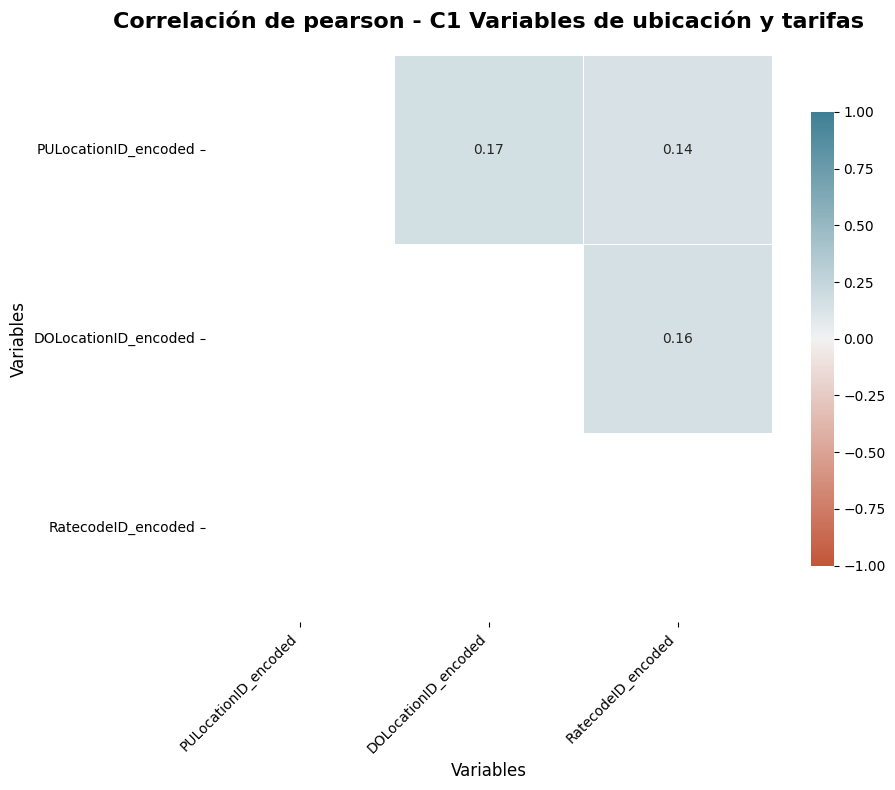


📊 ANÁLISIS DE CORRELACIÓN - C1 VARIABLES DE UBICACIÓN Y TARIFAS
🔄 Calculando correlaciones de spearman para 3 variables...

📈 RESUMEN ESTADÍSTICO - C1 Variables de ubicación y tarifas
--------------------------------------------------
Total de pares de variables: 3
Correlación promedio: 0.022
Correlación máxima: 0.105
Correlación mínima: -0.138
Desviación estándar: 0.113

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 3 pares


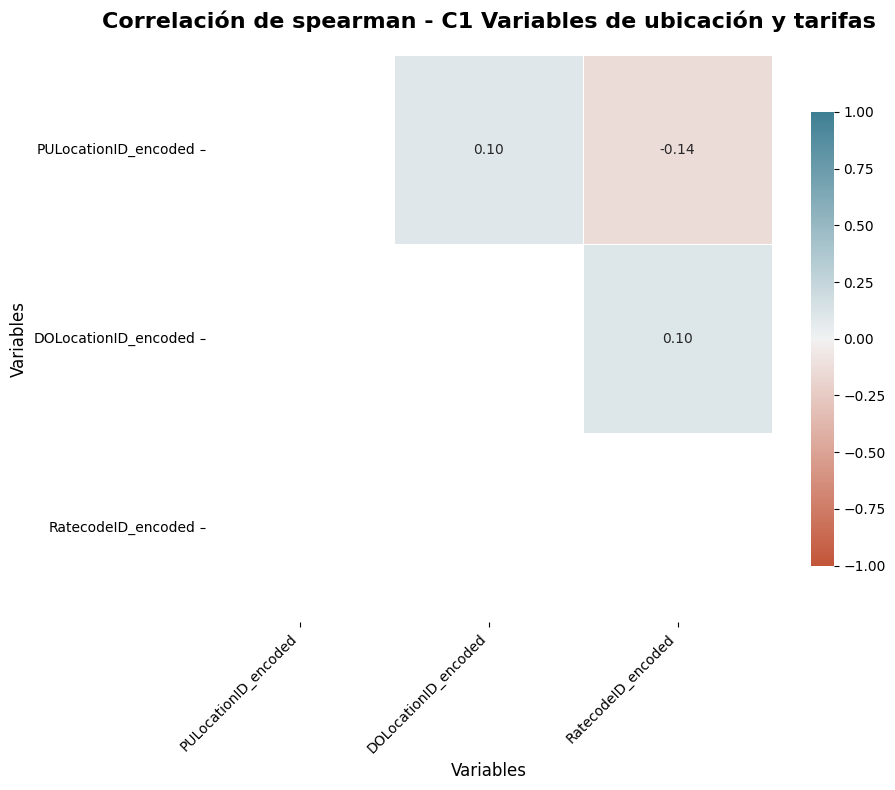

In [26]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c1,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c1,
    group_name = grupo_nombre,
    method = "spearman"
)

No hay correlación lineal ni no lineal entre estas variables.

In [27]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [28]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
	  spark=spark,
    format="json",
	group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "C1 Variables de ubicaci\u00f3n y tarifas",
  "total_rows": 3066715,
  "variables": {
    "PULocationID_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 256.0,
      "mean": 17.559552811395907,
      "median": 14.0,
      "std": 17.18371882298674,
      "q25": 5.0,
      "q75": 26.0,
      "n_outliers_iqr": 323141
    },
    "DOLocationID_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 260.0,
      "mean": 25.027602173661393,
      "median": 18.0,
      "std": 28.40529652147174,
      "q25": 7.0,
      "q75": 33.0,
      "n_outliers_iqr": 417225
    },
    "RatecodeID_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 6.0,
      "mean": 0.07869006412398935,
      "median": 0.0,
      "std": 0.41416143459854815,
      "q25": 0.0,
      "q75": 0.0,
      "n_outliers_iqr": 155705
   

- **Análisis de VIF**

In [29]:
analyze_vif(ds_for_correlation_clean, grupo_c1)

               Variable     VIF    Interpretacion
0  DOLocationID_encoded  1.0502  Baja correlación
1  PULocationID_encoded  1.0424  Baja correlación
2    RatecodeID_encoded  1.0401  Baja correlación

=== Variables con VIF aceptable ===



['PULocationID_encoded', 'DOLocationID_encoded', 'RatecodeID_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

Variables sin multicolinealidad.

- **Clustering**

Para k = 2, la silueta media es: 0.8181
Para k = 3, la silueta media es: 0.6054
Para k = 4, la silueta media es: 0.5610
Para k = 5, la silueta media es: 0.5516
Para k = 6, la silueta media es: 0.5468
Para k = 7, la silueta media es: 0.5408
Para k = 8, la silueta media es: 0.5559


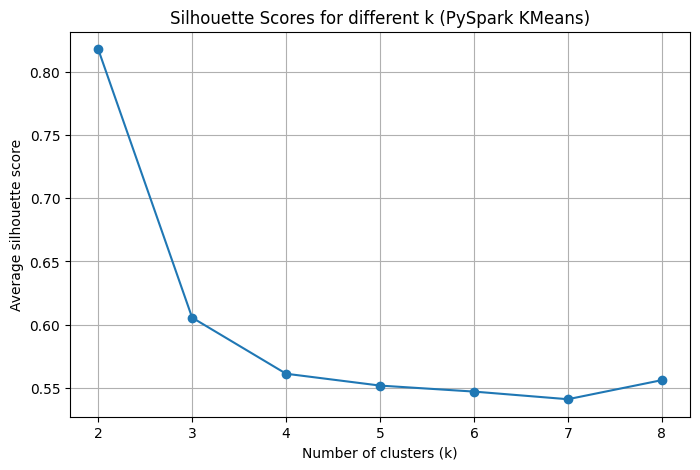

In [30]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_c1, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [31]:
k_optimo = 2

In [32]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_c1,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 2
- Variables utilizadas: ['PULocationID_encoded', 'DOLocationID_encoded', 'RatecodeID_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 1883037590.8295

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |2732318|
|1      |334397 |
+-------+-------+


⏱️ Tiempo de ejecución: 71.66 segundos
📊 Balance de clusters - Min: 334397,  Max: 2732318, Std: 1198960.50


In [33]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 2,
  "silhouette_score": 0.8181250794360989,
  "wssse": 1883037590.8294787,
  "cluster_sizes": [
    [
      1,
      334397
    ],
    [
      0,
      2732318
    ]
  ],
  "silhouette_all_k": {
    "2": 0.8181250794360989,
    "3": 0.6054196683769335,
    "4": 0.5609935764015376,
    "5": 0.5516056710425112,
    "6": 0.5468459262680179,
    "7": 0.540796575808298,
    "8": 0.555918271284971
  },
  "centers": [
    [
      16.69460253162333,
      17.345766854370538,
      0.05062514685333113
    ],
    [
      24.62695837582275,
      87.79496227537926,
      0.30800515554864427
    ]
  ]
}


In [34]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/c1_variables_de_ubic__silver_clusters_20251111_084111.parquet
  Registros: 3,066,715
  Clusters únicos: 2


- **Reducción de dimensionalidad**

In [35]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_c1, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [36]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


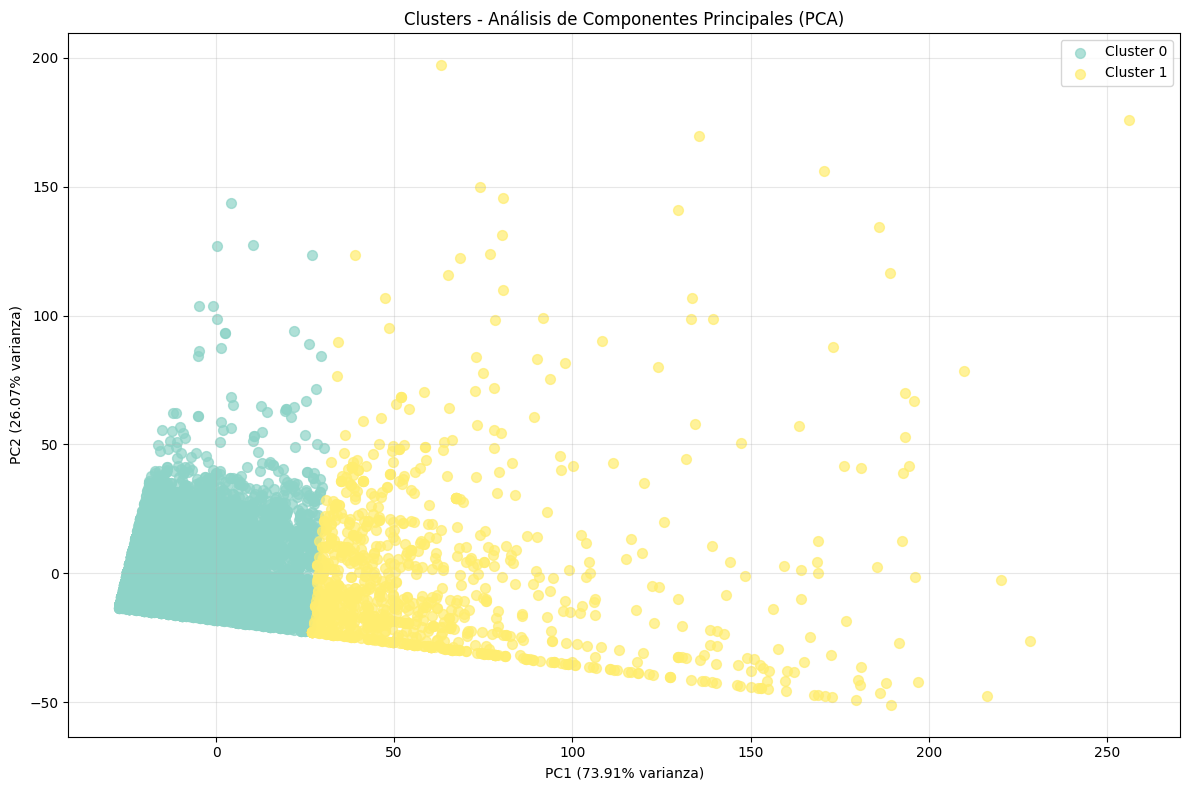

2. Perfiles de clusters...


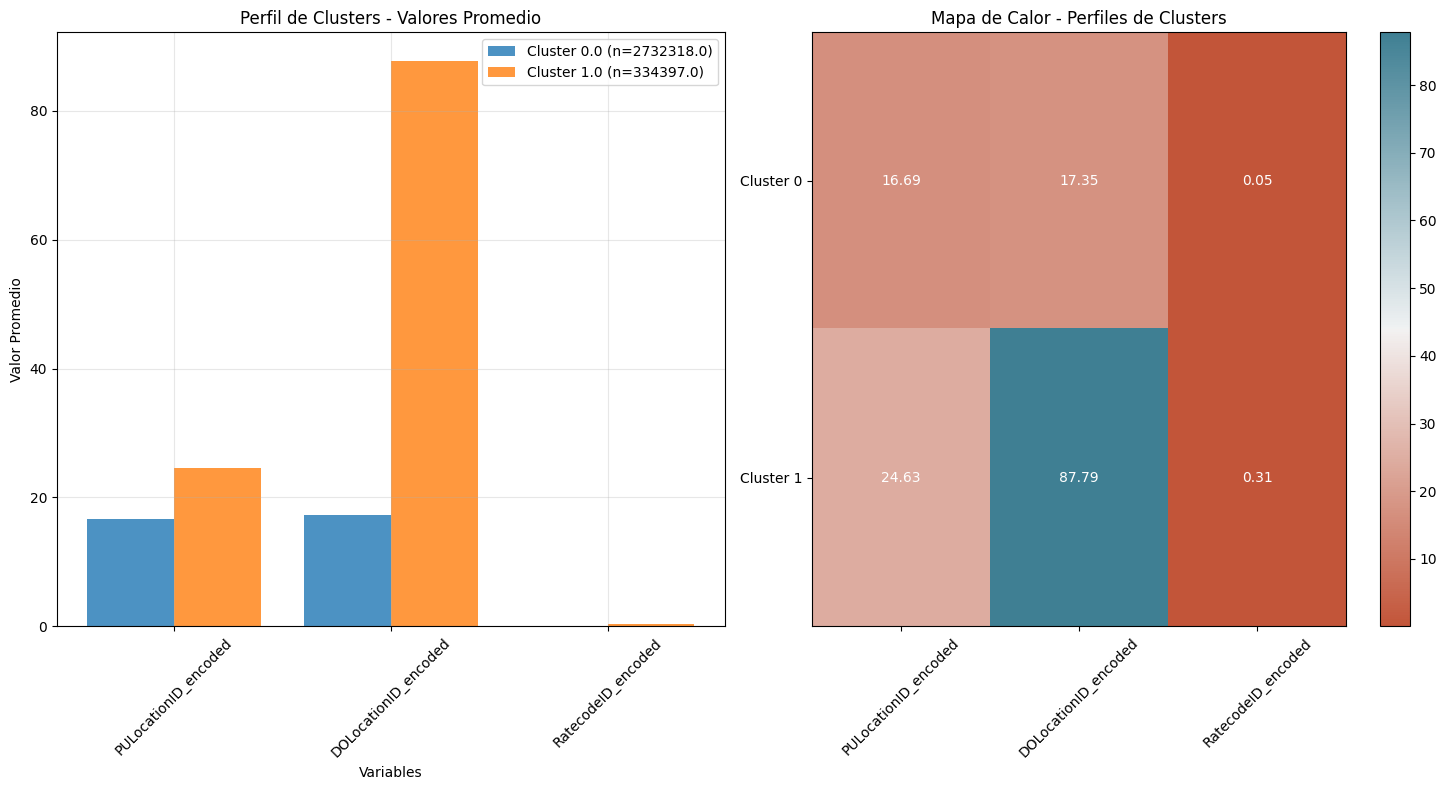

3. Distribución de clusters...


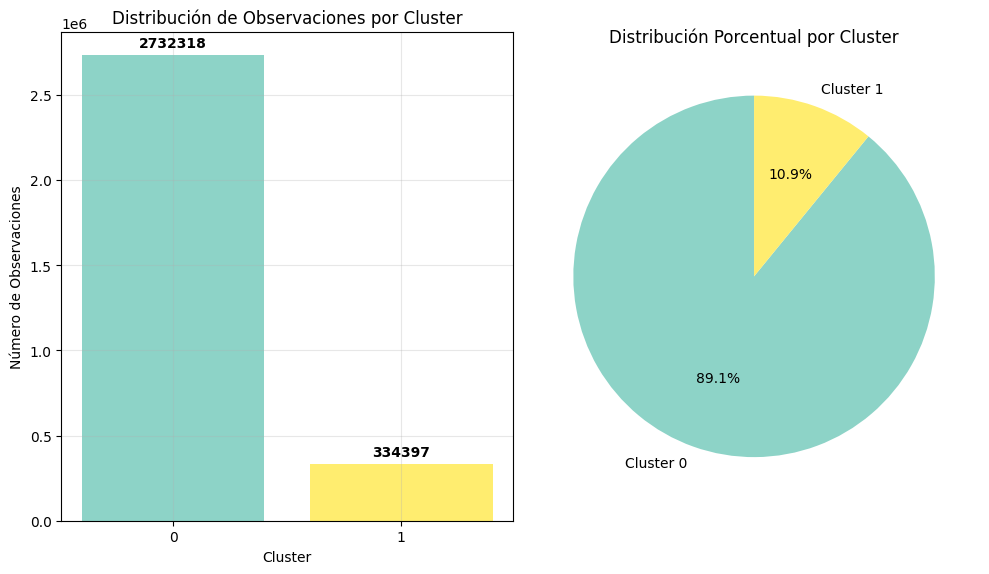

✅ Visualizaciones completadas!


In [37]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_c1,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

2 grupos perfectamente separados, ambas PC obtienen prácticamente el 100% de la varianza.

Uno de los cluster es mayoritario, con valores promedio inferiores al otro. Es probable que el cluster mayoritario corresponda a trayectos frecuentes entre zonas comunes con tarifas estándar, y el cluster minoritario a trayectos menos frecuentes entre zonas con códigos más altos y/o tarifas especiales. Por ejemplo, el cluster mayoritario serían viajes típicos urbanos, y el minoritario viajes especiales (aeropuerto, zonas menos céntricas, tarifas altas...)

In [38]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [39]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c1_variables_de_ubic__silver_transformations_pca_20251111_084136.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [40]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/c1_variables_de_ubic__silver_logs_20251111_084138.parquet
  Total de registros en log: 1


In [41]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.30 GB / 13.61 GB (48.7%)
[Inicio] Disco usado: 42.43 GB / 115.66 GB (36.7%)


[Final] Memoria usada: 6.30 GB / 13.61 GB (48.7%)
[Final] Disco usado: 42.43 GB / 115.66 GB (36.7%)



In [42]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.29 GB / 13.61 GB (48.7%)
[Inicio limpieza completa de memoria] Disco usado: 42.43 GB / 115.66 GB (36.7%)


[Final limpieza completa de memoria] Memoria usada: 2.13 GB / 13.61 GB (18.1%)
[Final limpieza completa de memoria] Disco usado: 42.43 GB / 115.66 GB (36.7%)



### **Grupo C-2: Variables de propinas**

In [43]:
grupo_c2 = [
    "tip_amount_encoded",
    "tip_score_encoded",
    "payment_type"
]

grupo_nombre = "C2 Variables de propinas"

In [44]:
# gestión de metadatos
params = {
    "features": grupo_c2,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "C2 Variables de propinas",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "tip_amount_encoded",
      "tip_score_encoded",
      "payment_type"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-11T08:42:11.473399",
  "model_version": "ed6564ed87e5",
  "featureset_version": "C2 Variables de propinas_ed6564ed87e5",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [45]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_c2,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c2_variables_de_prop__silver_features_20251111_084212.parquet
  Registros: 3,066,715
  Columnas: 8


In [46]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_c2,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - C2 VARIABLES DE PROPINAS
🔄 Calculando correlaciones de pearson para 3 variables...

📈 RESUMEN ESTADÍSTICO - C2 Variables de propinas
--------------------------------------------------
Total de pares de variables: 3
Correlación promedio: -0.183
Correlación máxima: 0.431
Correlación mínima: -0.615
Desviación estándar: 0.446

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 3 pares
Bajo (|r| ≤ 0.3): 0 pares


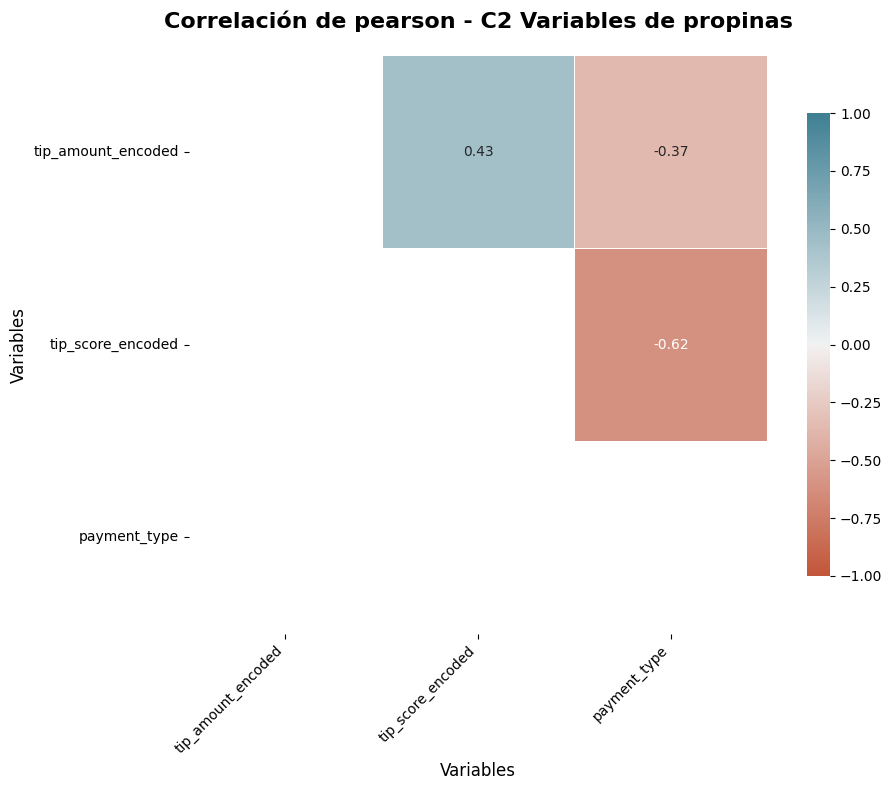


📊 ANÁLISIS DE CORRELACIÓN - C2 VARIABLES DE PROPINAS
🔄 Calculando correlaciones de spearman para 3 variables...

📈 RESUMEN ESTADÍSTICO - C2 Variables de propinas
--------------------------------------------------
Total de pares de variables: 3
Correlación promedio: -0.206
Correlación máxima: 0.598
Correlación mínima: -0.618
Desviación estándar: 0.568

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 3 pares
Bajo (|r| ≤ 0.3): 0 pares


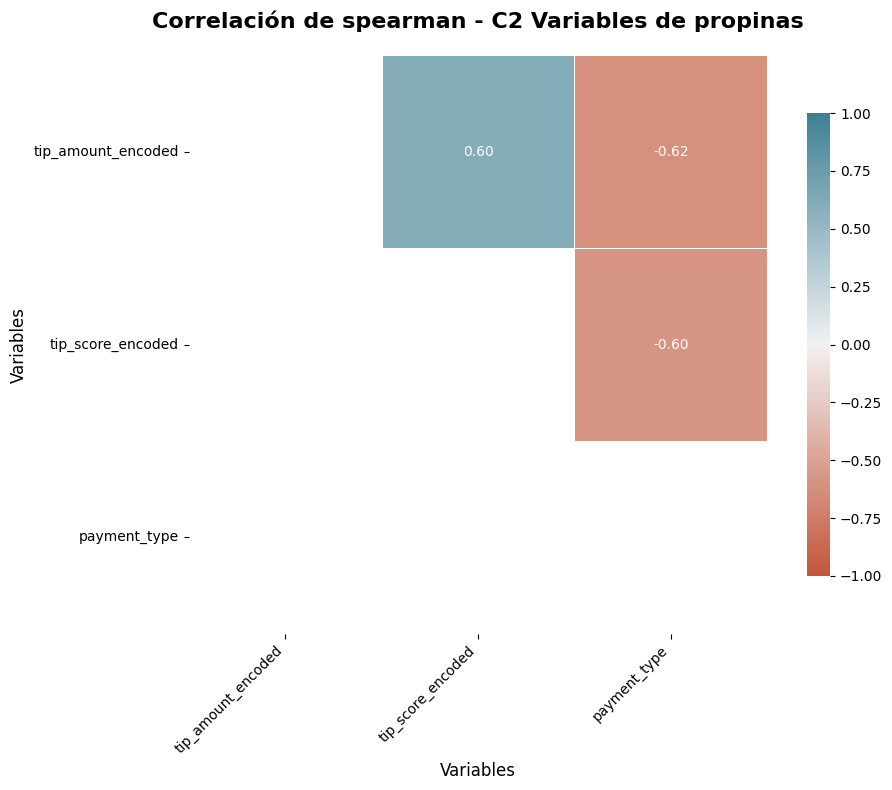

In [47]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c2,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c2,
    group_name = grupo_nombre,
    method = "spearman"
)

Correlaciones moderadas lineales y no lineales entre las tres variables, lo que refleja que la propina está relacionada con el tipo de pago.

In [48]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [49]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
	  spark=spark,
    format="json",
	  group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "C2 Variables de propinas",
  "total_rows": 3066715,
  "variables": {
    "tip_amount_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -0.8805166318031237,
      "max": 98.66864164298886,
      "mean": -3.5750195475172905e-14,
      "median": -0.1746796377329074,
      "std": 1.000000000000013,
      "q25": -0.6190955228882288,
      "q75": 0.21745202563943494,
      "n_outliers_iqr": 400704
    },
    "tip_score_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -1.5084903288061562,
      "max": 2.1081045457977523,
      "mean": -3.2391909591115327e-13,
      "median": 0.3216431530217084,
      "std": 0.9999999999999519,
      "q25": -1.0362093153828589,
      "q75": 0.718060344323617,
      "n_outliers_iqr": 78325
    },
    "payment_type": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 4.0,
      "mean": 1.194480739162263

- **Análisis de VIF**

In [50]:
analyze_vif(ds_for_correlation_clean, grupo_c2)

             Variable     VIF    Interpretacion
0   tip_score_encoded  1.7464  Baja correlación
1        payment_type  1.6411  Baja correlación
2  tip_amount_encoded  1.2527  Baja correlación

=== Variables con VIF aceptable ===



['tip_amount_encoded', 'tip_score_encoded', 'payment_type']


=== Variables con VIF no aceptable (>= 10) ===



[]

Variables sin multicolinealidad.

- **Clustering**

Para k = 2, la silueta media es: 0.6777
Para k = 3, la silueta media es: 0.7574
Para k = 4, la silueta media es: 0.4005
Para k = 5, la silueta media es: 0.6905
Para k = 6, la silueta media es: 0.5900
Para k = 7, la silueta media es: 0.6669
Para k = 8, la silueta media es: 0.6779


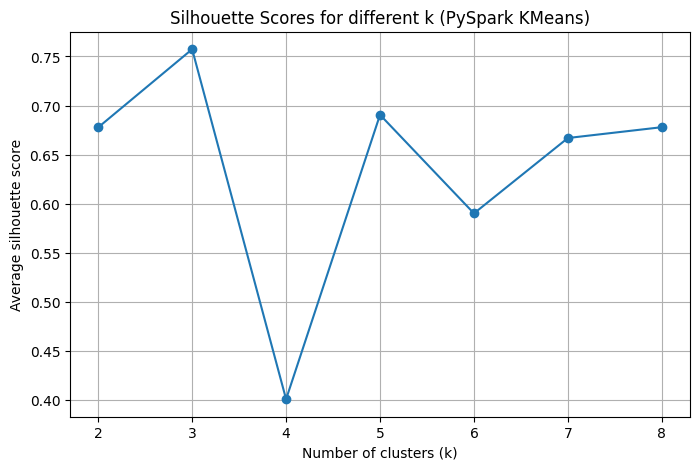

In [51]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_c2, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [52]:
k_optimo = 3

In [53]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_c2,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 3
- Variables utilizadas: ['tip_amount_encoded', 'tip_score_encoded', 'payment_type']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 1969129.2453

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |1903527|
|1      |934056 |
|2      |229132 |
+-------+-------+


⏱️ Tiempo de ejecución: 66.08 segundos
📊 Balance de clusters - Min: 229132,  Max: 1903527, Std: 686406.95


In [54]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 3,
  "silhouette_score": 0.7574173042535904,
  "wssse": 1969129.2452796442,
  "cluster_sizes": [
    [
      1,
      934056
    ],
    [
      2,
      229132
    ],
    [
      0,
      1903527
    ]
  ],
  "silhouette_all_k": {
    "2": 0.6777313847379185,
    "3": 0.7574173042535904,
    "4": 0.4005185898267384,
    "5": 0.6905465812036948,
    "6": 0.5900142459796733,
    "7": 0.6668785982113571,
    "8": 0.6779126770883767
  },
  "centers": [
    [
      0.051228268165591326,
      0.6046776543829174,
      0.971838592255324
    ],
    [
      -0.777636520300582,
      -1.3299762663429735,
      1.7004258845294073
    ],
    [
      2.7444515213639753,
      0.39825109550233234,
      0.9816088542848664
    ]
  ]
}


In [55]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/c2_variables_de_prop__silver_clusters_20251111_090603.parquet
  Registros: 3,066,715
  Clusters únicos: 3


- **Reducción de dimensionalidad**

In [56]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_c2, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [57]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


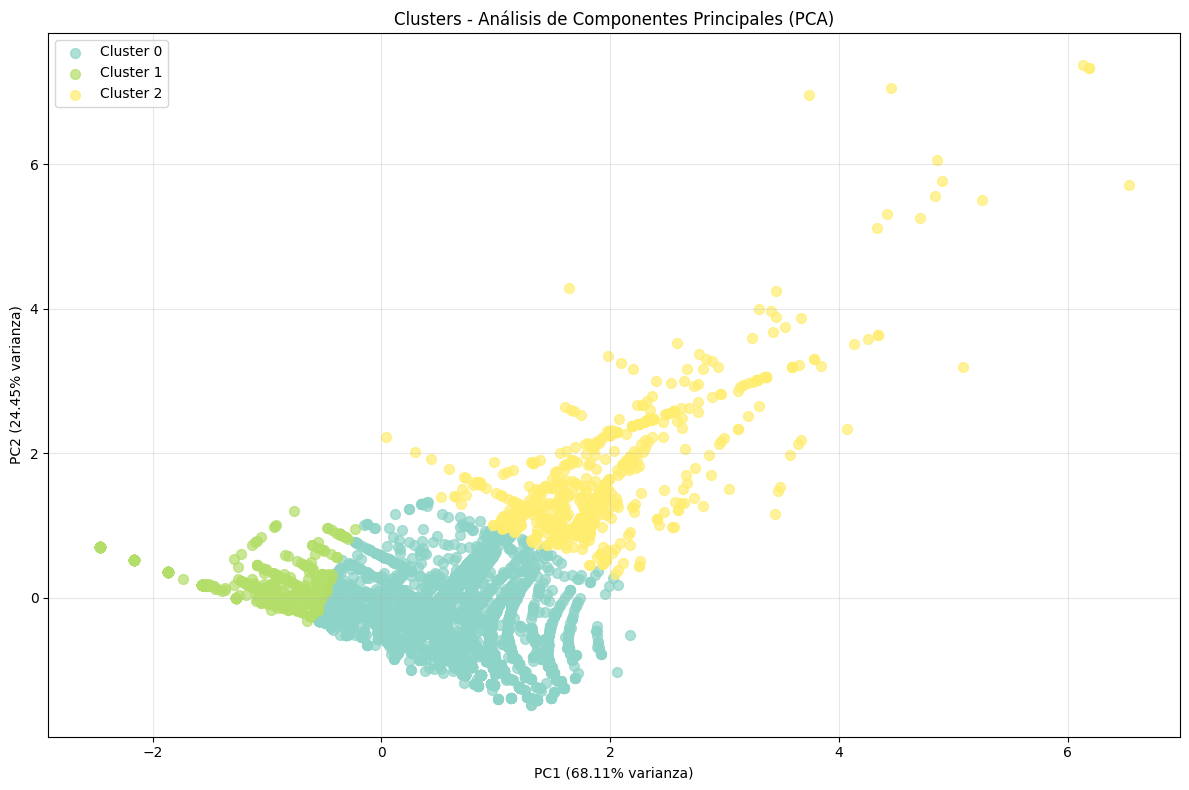

2. Perfiles de clusters...


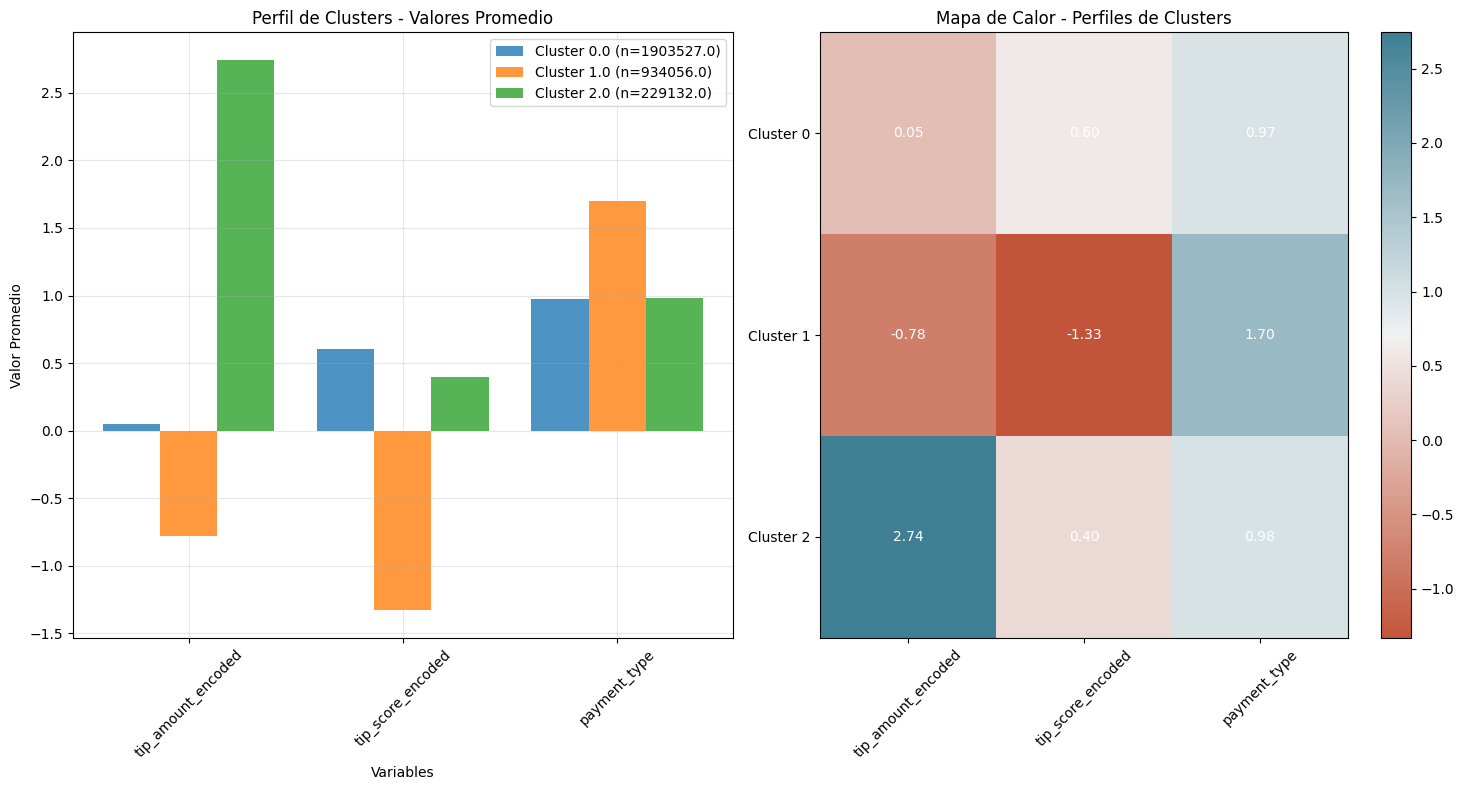

3. Distribución de clusters...


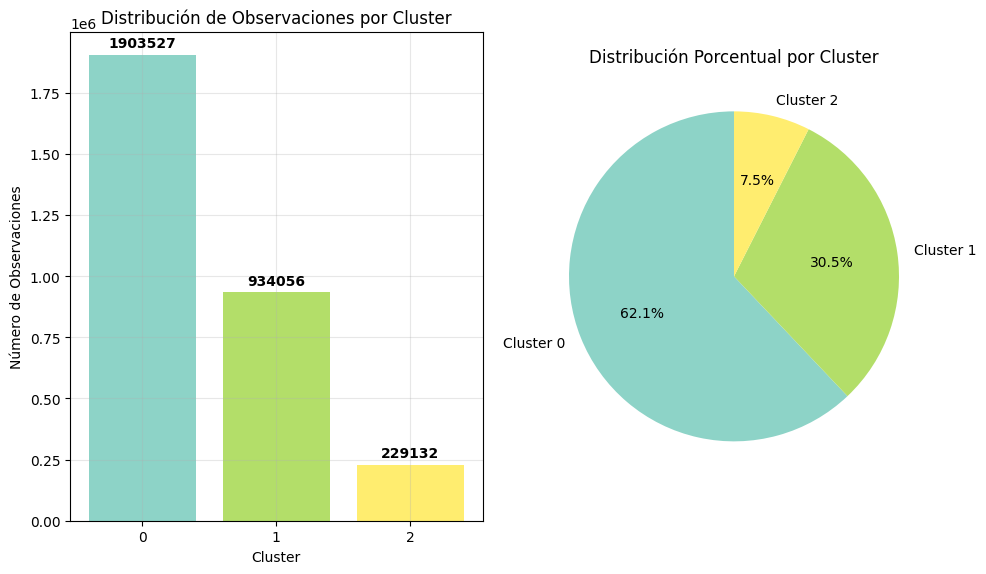

✅ Visualizaciones completadas!


In [58]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_c2,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

3 grupos separados, ambas PC obtienen más del 90% de la varianza.

Un cluster mayoritario, otro minoritario y el tercero intermedio. El intermedio tiene valores medios negativos para la propina y positivos para el tipo de pago, y tiene los valores más elevados tanto para el tipo de pago como para tip_score; para tip_amount, el valor más elevado con diferencia lo tiene
el cluster minoritario.

El cluster mayoritario serían viajes normales, con tipos de pago habituales y propinas bajas o moderadas.

El cluster minoritario, propinas de importe alto, seguramente trayectos largos y/o tarifas altas, por lo que el porcentaje de propina no es alto aunque la propina sí lo sea.

El cluster intermedio, viajes menos habituales, predominio de ciertos métodos de pago y porcentajes altos de propina.

In [59]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [60]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c2_variables_de_prop__silver_transformations_pca_20251111_090959.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [61]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/c2_variables_de_prop__silver_logs_20251111_091001.parquet
  Total de registros en log: 1


In [62]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.29 GB / 13.61 GB (48.7%)
[Inicio] Disco usado: 42.47 GB / 115.66 GB (36.7%)


[Final] Memoria usada: 6.29 GB / 13.61 GB (48.7%)
[Final] Disco usado: 42.47 GB / 115.66 GB (36.7%)



In [63]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.29 GB / 13.61 GB (48.7%)
[Inicio limpieza completa de memoria] Disco usado: 42.47 GB / 115.66 GB (36.7%)


[Final limpieza completa de memoria] Memoria usada: 2.35 GB / 13.61 GB (19.8%)
[Final limpieza completa de memoria] Disco usado: 42.47 GB / 115.66 GB (36.7%)



### **Grupo C-3: Variables de servicio**

In [64]:
grupo_c3 = [
    "passenger_count_encoded",
    "trip_distance_encoded",
    "trip_duration_minutes_encoded"
]

grupo_nombre = "C3 Variables de servicio"

In [65]:
# gestión de metadatos
params = {
    "features": grupo_c3,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "C3 Variables de servicio",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "passenger_count_encoded",
      "trip_distance_encoded",
      "trip_duration_minutes_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-11T09:10:06.746663",
  "model_version": "2a20420fe701",
  "featureset_version": "C3 Variables de servicio_2a20420fe701",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [66]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_c3,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c3_variables_de_serv__silver_features_20251111_091007.parquet
  Registros: 3,066,715
  Columnas: 8


In [67]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_c3,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - C3 VARIABLES DE SERVICIO
🔄 Calculando correlaciones de pearson para 3 variables...

📈 RESUMEN ESTADÍSTICO - C3 Variables de servicio
--------------------------------------------------
Total de pares de variables: 3
Correlación promedio: 0.013
Correlación máxima: 0.023
Correlación mínima: -0.000
Desviación estándar: 0.010

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 3 pares


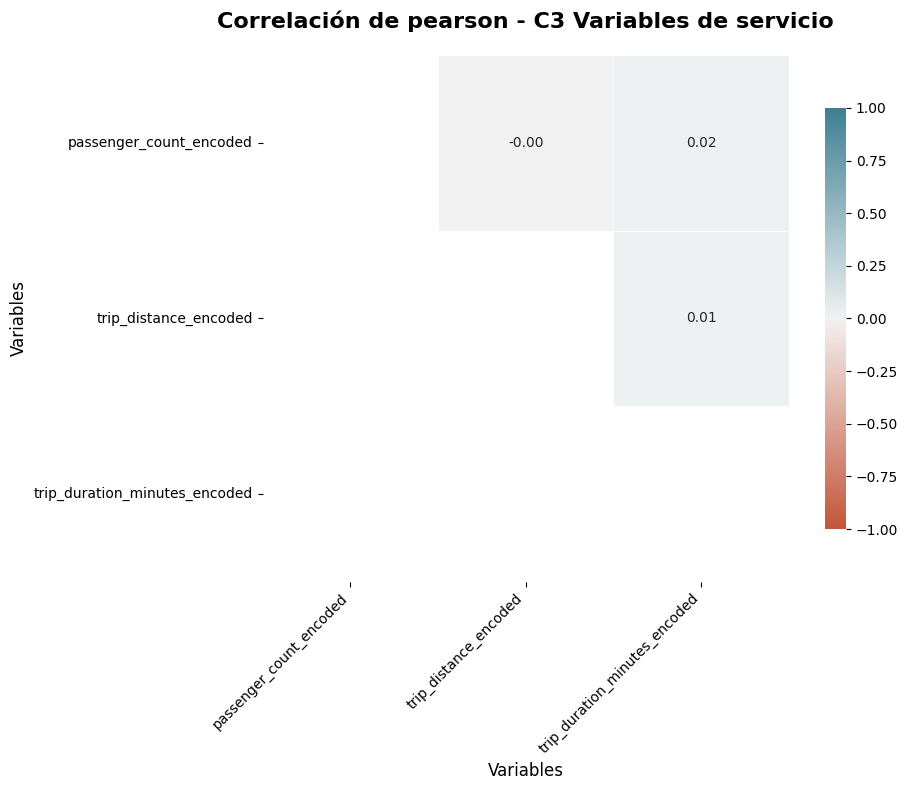


📊 ANÁLISIS DE CORRELACIÓN - C3 VARIABLES DE SERVICIO
🔄 Calculando correlaciones de spearman para 3 variables...

📈 RESUMEN ESTADÍSTICO - C3 Variables de servicio
--------------------------------------------------
Total de pares de variables: 3
Correlación promedio: 0.306
Correlación máxima: 0.862
Correlación mínima: 0.027
Desviación estándar: 0.393

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 1 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 2 pares


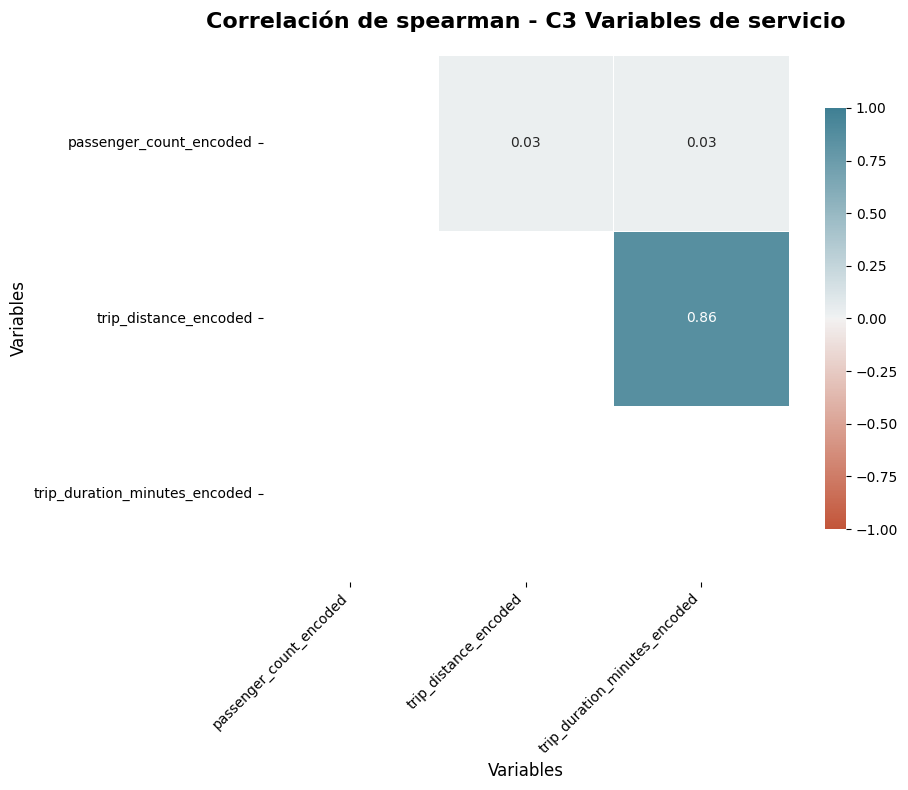

In [68]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c3,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c3,
    group_name = grupo_nombre,
    method = "spearman"
)

No hay correlación lineal entre estas variables, pero sí hay una correlación no lineal alta entre trip_distance y trip_duration_minutes. Es lógico que la distancia influya en la duración del trayecto.

In [69]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [70]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
	  spark=spark,
    format="json",
	  group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "C3 Variables de servicio",
  "total_rows": 3066715,
  "variables": {
    "passenger_count_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 8.0,
      "mean": 0.3707344829891268,
      "median": 0.0,
      "std": 0.8708899775475627,
      "q25": 0.0,
      "q75": 0.0,
      "n_outliers_iqr": 682451
    },
    "trip_distance_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -0.015504785875246022,
      "max": 1037.371977155861,
      "mean": -1.6782906439206588e-16,
      "median": -0.008333206947302121,
      "std": 0.9999999999999981,
      "q25": -0.011257929079927285,
      "q75": -0.002323503935058629,
      "n_outliers_iqr": 573232
    },
    "trip_duration_minutes_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -1.4157746634598511,
      "max": 4.115579432477305,
      "mean": 3.2286669690887127e-14,
      "m

- **Análisis de VIF**

In [71]:
analyze_vif(ds_for_correlation_clean, grupo_c3)

                        Variable     VIF    Interpretacion
0  trip_duration_minutes_encoded  1.0008  Baja correlación
1        passenger_count_encoded  1.0005  Baja correlación
2          trip_distance_encoded  1.0002  Baja correlación

=== Variables con VIF aceptable ===



['passenger_count_encoded',
 'trip_distance_encoded',
 'trip_duration_minutes_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

Variables sin multicolinealidad.

- **Clustering**

Para k = 2, la silueta media es: 0.6142
Para k = 3, la silueta media es: 0.6472
Para k = 4, la silueta media es: 0.7295
Para k = 5, la silueta media es: 0.7427
Para k = 6, la silueta media es: 0.6492
Para k = 7, la silueta media es: 0.5311
Para k = 8, la silueta media es: 0.5247


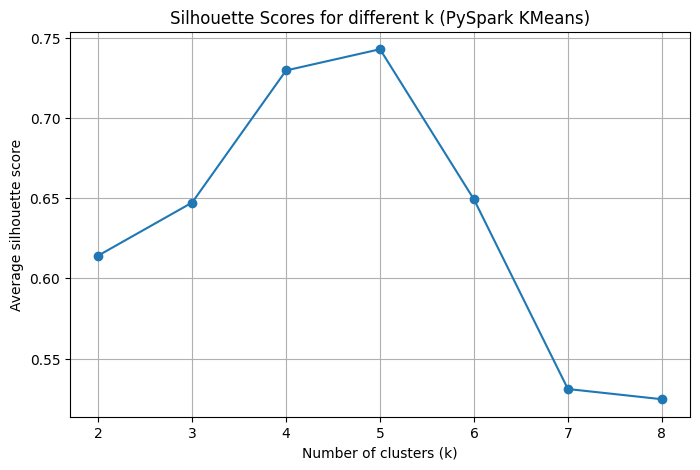

In [72]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_c3, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [73]:
k_optimo = 5

In [74]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_c3,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 5
- Variables utilizadas: ['passenger_count_encoded', 'trip_distance_encoded', 'trip_duration_minutes_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 1977269.9176

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |1938791|
|1      |547378 |
|2      |457861 |
|3      |4      |
|4      |122681 |
+-------+-------+


⏱️ Tiempo de ejecución: 69.57 segundos
📊 Balance de clusters - Min: 4,  Max: 1938791, Std: 693148.23


Estas variables también presentan un cluster sin apenas registros.

In [75]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 5,
  "silhouette_score": 0.7427354637939279,
  "wssse": 1977269.9176054692,
  "cluster_sizes": [
    [
      1,
      547378
    ],
    [
      3,
      4
    ],
    [
      4,
      122681
    ],
    [
      2,
      457861
    ],
    [
      0,
      1938791
    ]
  ],
  "silhouette_all_k": {
    "2": 0.6141823679173265,
    "3": 0.6472265011880755,
    "4": 0.72951853077509,
    "5": 0.7427354637939279,
    "6": 0.6491627632570838,
    "7": 0.5310737998013627,
    "8": 0.5247163096947224
  },
  "centers": [
    [
      0.0,
      -0.007487349348658396,
      -0.4001730622300336
    ],
    [
      0.21634227170255288,
      0.027033677198766738,
      1.6969852371234875
    ],
    [
      1.2044638001489534,
      -0.006902676393925573,
      -0.32665796396222907
    ],
    [
      0.0,
      790.4883292623681,
      -0.06425987529520025
    ],
    [
      3.8069383197072075,
      -0.00230452659588683,
      -0.028335720731408918
    ]
  ]
}


In [76]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/c3_variables_de_serv__silver_clusters_20251111_094259.parquet
  Registros: 3,066,715
  Clusters únicos: 5


- **Reducción de dimensionalidad**

In [77]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_c3, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [78]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


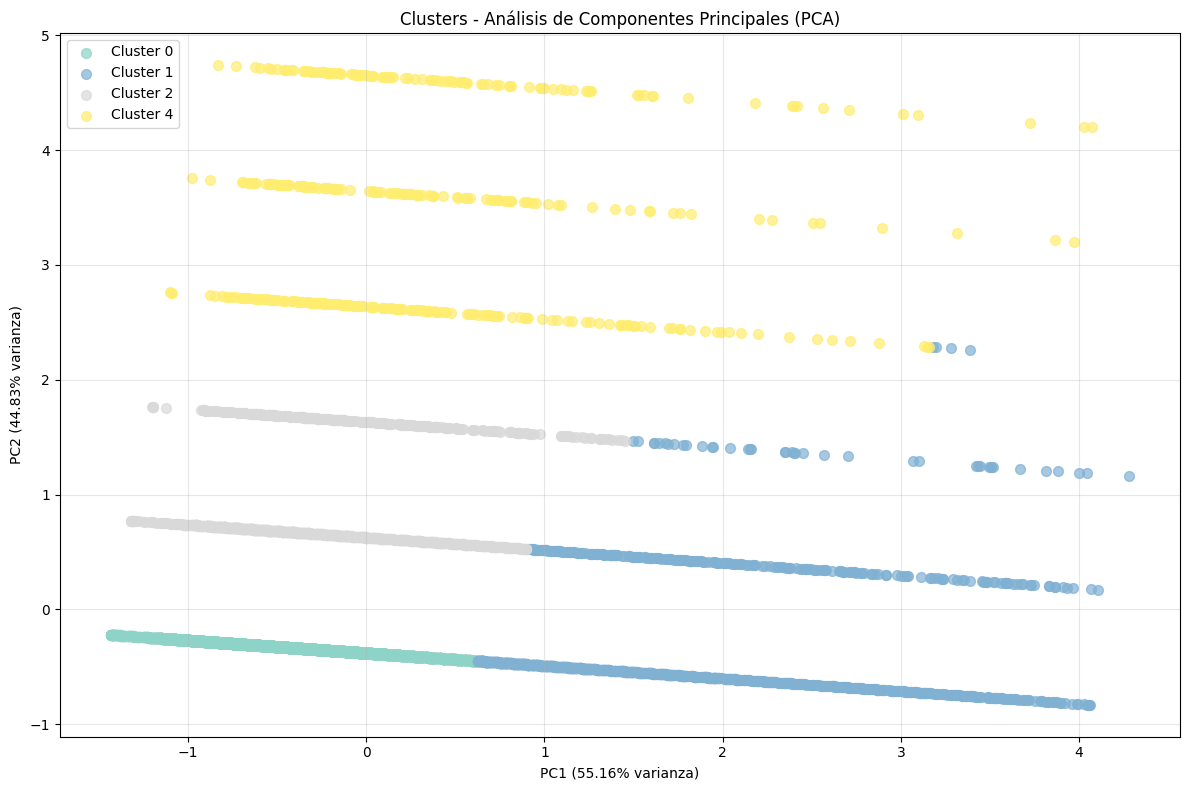

2. Perfiles de clusters...


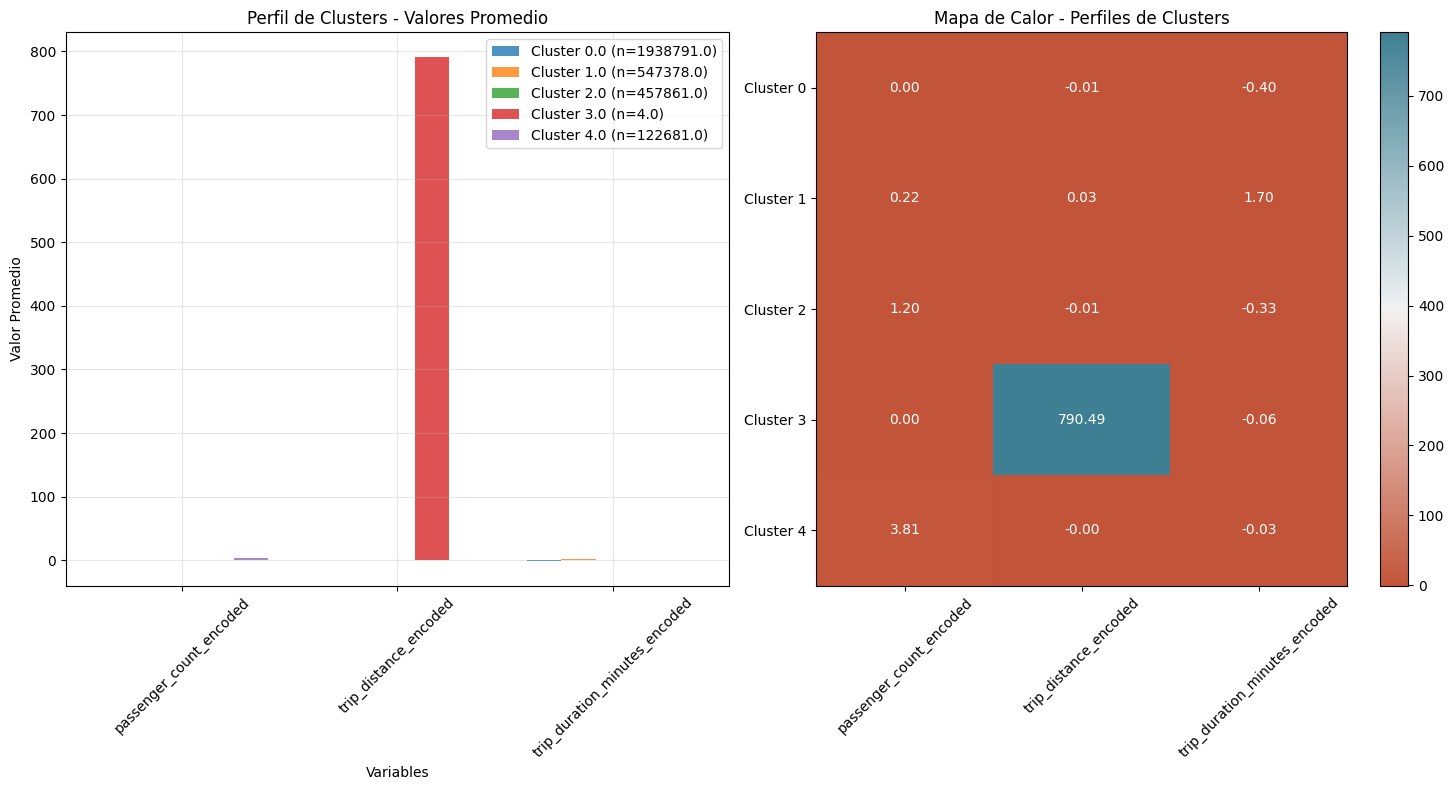

3. Distribución de clusters...


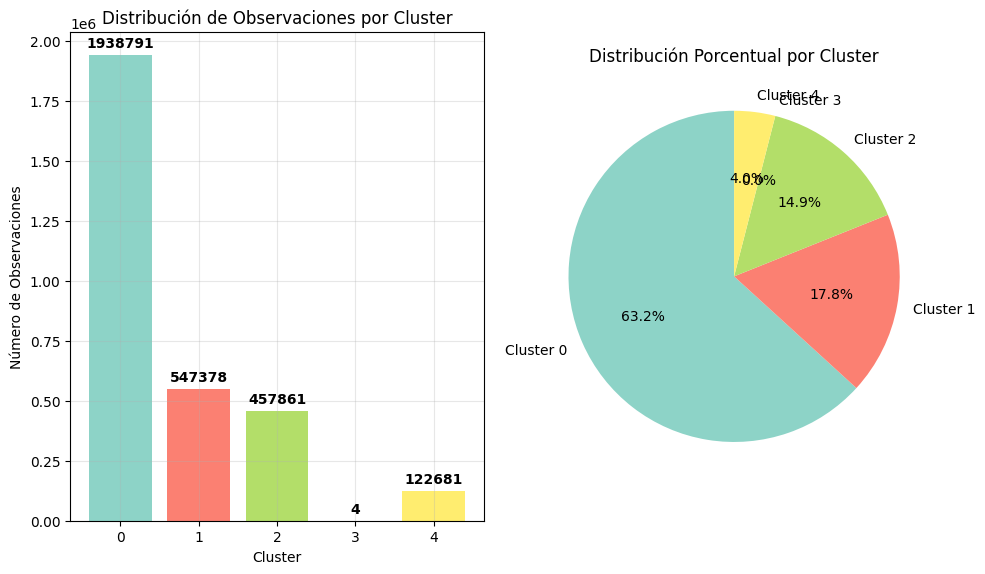

✅ Visualizaciones completadas!


In [79]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_c3,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

Separación clara entre 3 de los 4 clusters, principalmente en PC1; ambas componentes principales cubren el 100% de la varianza. El cuarto grupo está prácticamente vacío, no es relevante; destaca por un valor muy elevado de la distancia del viaje.

Entre los clusters principales, uno es mayoritario; se diferencian en la cantidad de pasajeros, no hay muchas diferencias en cuanto a la distancia y uno de los grupos destaca por la duración del trayecto.

El grupo mayoritario serían los viajes habituales: pocos pasajeros, trayectos cortos, poca duración.

Los grupos minoritarios serían más largos, más pasajeros, mayor duración.

In [80]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [81]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c3_variables_de_serv__silver_transformations_pca_20251111_094838.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [82]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/c3_variables_de_serv__silver_logs_20251111_094841.parquet
  Total de registros en log: 1


In [83]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 2.41 GB / 13.61 GB (20.2%)
[Inicio] Disco usado: 42.51 GB / 115.66 GB (36.8%)


[Final] Memoria usada: 2.41 GB / 13.61 GB (20.2%)
[Final] Disco usado: 42.51 GB / 115.66 GB (36.8%)



In [84]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 2.41 GB / 13.61 GB (20.2%)
[Inicio limpieza completa de memoria] Disco usado: 42.51 GB / 115.66 GB (36.8%)


[Final limpieza completa de memoria] Memoria usada: 2.41 GB / 13.61 GB (20.2%)
[Final limpieza completa de memoria] Disco usado: 42.51 GB / 115.66 GB (36.8%)



### **Grupo C-4: Variables técnicas/operativas**

In [85]:
grupo_c4 = [
    "store_and_fwd_flag_encoded",
    "VendorID_encoded"
]

grupo_nombre = "C4 Variables técnicas/operativas"

In [86]:
# gestión de metadatos
params = {
    "features": grupo_c4,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "C4 Variables t\u00e9cnicas/operativas",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "store_and_fwd_flag_encoded",
      "VendorID_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-11T09:48:47.777730",
  "model_version": "47e4ec775fa2",
  "featureset_version": "C4 Variables t\u00e9cnicas/operativas_47e4ec775fa2",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [87]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_c4,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c4_variables_técnica__silver_features_20251111_094848.parquet
  Registros: 3,066,715
  Columnas: 7


In [88]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_c4,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - C4 VARIABLES TÉCNICAS/OPERATIVAS
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - C4 Variables técnicas/operativas
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.100
Correlación máxima: 0.100
Correlación mínima: 0.100
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


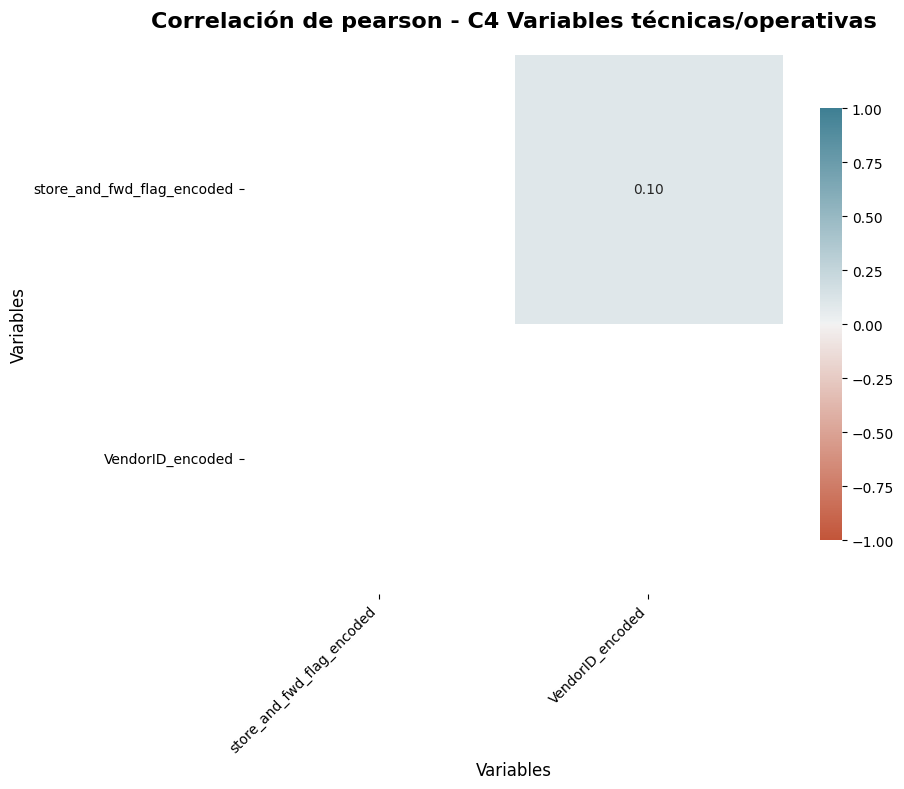


📊 ANÁLISIS DE CORRELACIÓN - C4 VARIABLES TÉCNICAS/OPERATIVAS
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - C4 Variables técnicas/operativas
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.100
Correlación máxima: 0.100
Correlación mínima: 0.100
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


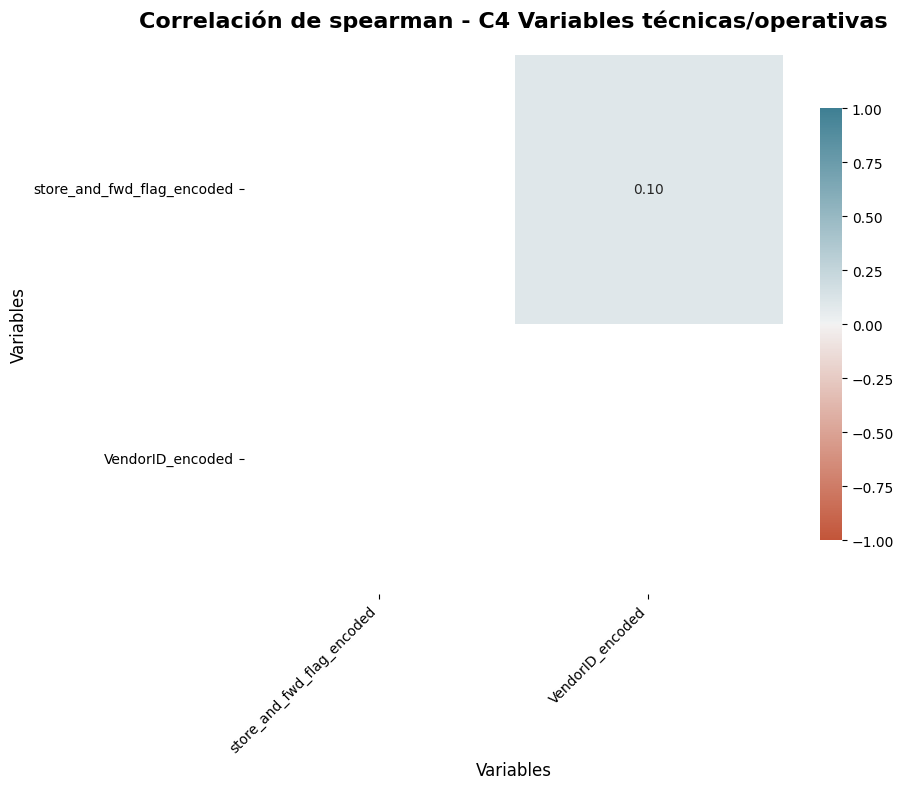

In [89]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c4,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c4,
    group_name = grupo_nombre,
    method = "spearman"
)

No hay correlación entre estas variables.

In [90]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [91]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
	  spark=spark,
    format="json",
	  group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "C4 Variables t\u00e9cnicas/operativas",
  "total_rows": 3066715,
  "variables": {
    "store_and_fwd_flag_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 1.0,
      "mean": 0.006522614589226583,
      "median": 0.0,
      "std": 0.08049889565193391,
      "q25": 0.0,
      "q75": 0.0,
      "n_outliers_iqr": 20003
    },
    "VendorID_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 1.0,
      "mean": 0.269789008760188,
      "median": 0.0,
      "std": 0.4438501591207039,
      "q25": 0.0,
      "q75": 1.0,
      "n_outliers_iqr": 0
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_correlation": 0.0998102683848872,
        "max_correlation": 0.0998102683848872,
        "min_correlation": 0.0998102683848872,
        "std_correlation": 0.0,
        "high_corre

- **Análisis de VIF**

In [92]:
analyze_vif(ds_for_correlation_clean, grupo_c4)

                     Variable     VIF    Interpretacion
0  store_and_fwd_flag_encoded  1.0101  Baja correlación
1            VendorID_encoded  1.0101  Baja correlación

=== Variables con VIF aceptable ===



['store_and_fwd_flag_encoded', 'VendorID_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

Confirma que no hay correlación lineal entre estas variables.

- **Clustering**

Para k = 2, la silueta media es: 0.9904
Para k = 3, la silueta media es: 0.9976
Para k = 4, la silueta media es: 1.0000
Para k = 5, la silueta media es: 1.0000
Para k = 6, la silueta media es: 1.0000
Para k = 7, la silueta media es: 1.0000
Para k = 8, la silueta media es: 1.0000


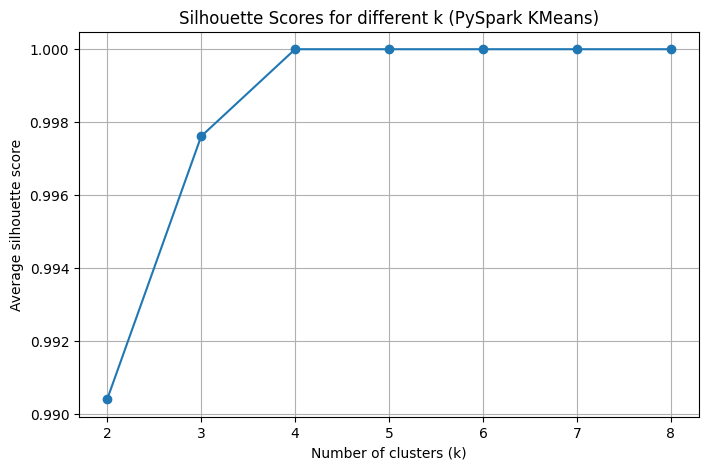

In [93]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_c4, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [94]:
k_optimo = 4

In [95]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_c4,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 4
- Variables utilizadas: ['store_and_fwd_flag_encoded', 'VendorID_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 0.0000

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |2235679|
|1      |811033 |
|2      |16333  |
|3      |3670   |
+-------+-------+


⏱️ Tiempo de ejecución: 60.59 segundos
📊 Balance de clusters - Min: 3670,  Max: 2235679, Std: 909000.84


In [96]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 4,
  "silhouette_score": 1.0,
  "wssse": 0.0,
  "cluster_sizes": [
    [
      1,
      811033
    ],
    [
      3,
      3670
    ],
    [
      2,
      16333
    ],
    [
      0,
      2235679
    ]
  ],
  "silhouette_all_k": {
    "2": 0.990400292426271,
    "3": 0.9976104809374613,
    "4": 1.0,
    "5": 1.0,
    "6": 1.0,
    "7": 1.0,
    "8": 1.0
  },
  "centers": [
    [
      0.0,
      0.0
    ],
    [
      0.0,
      1.0
    ],
    [
      0.9999999999999999,
      0.9999999999999999
    ],
    [
      1.0,
      0.0
    ]
  ]
}


In [97]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/c4_variables_técnica__silver_clusters_20251111_100401.parquet
  Registros: 3,066,715
  Clusters únicos: 4


- **Reducción de dimensionalidad**

In [98]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_c4, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [99]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


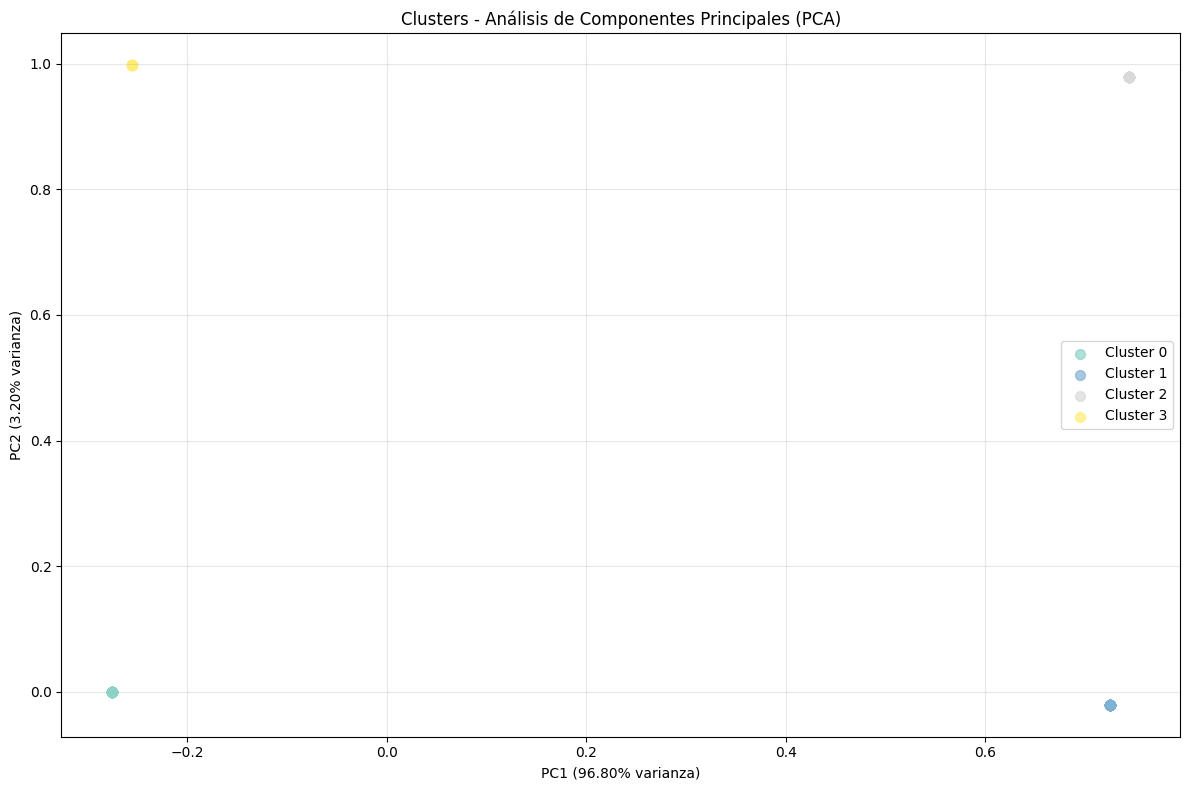

2. Perfiles de clusters...


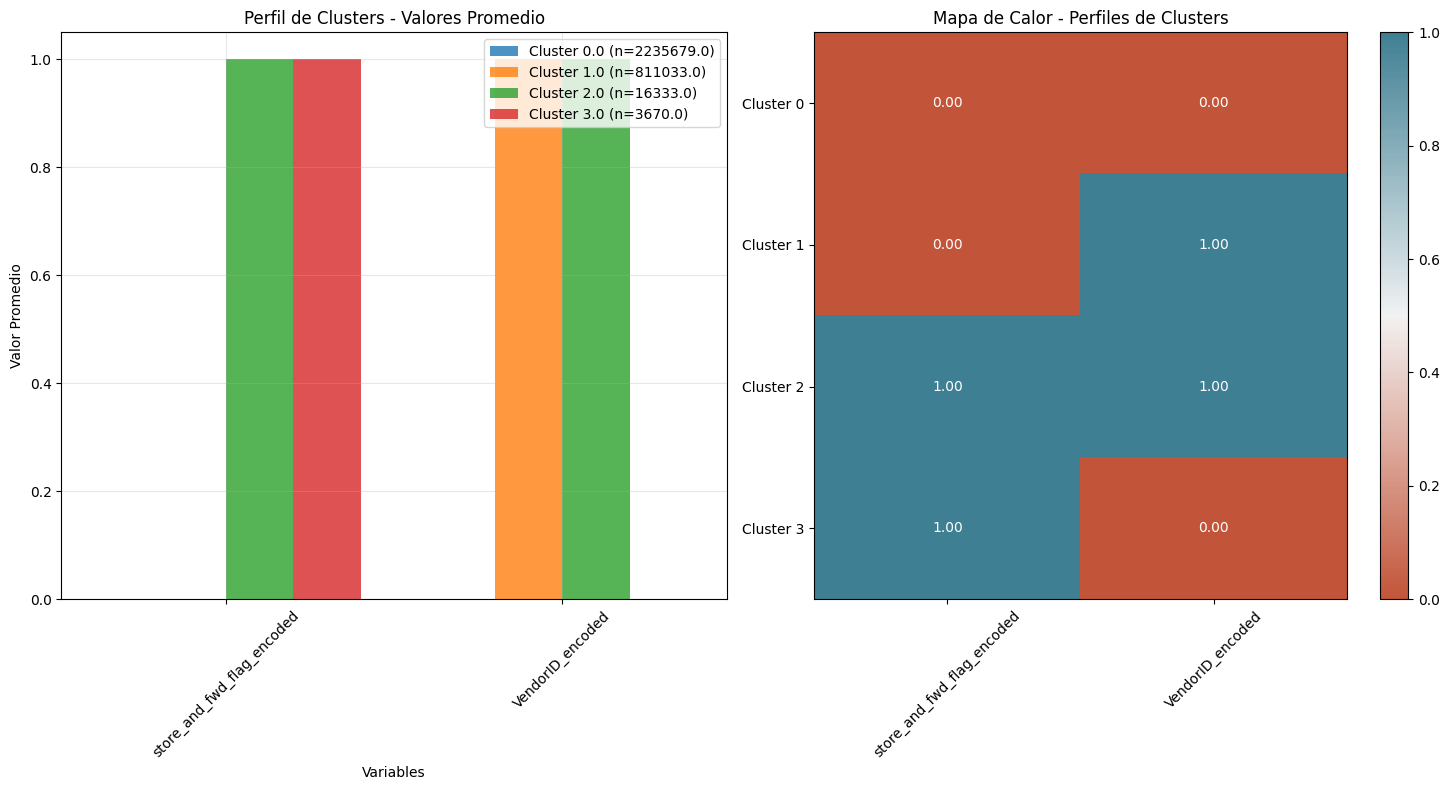

3. Distribución de clusters...


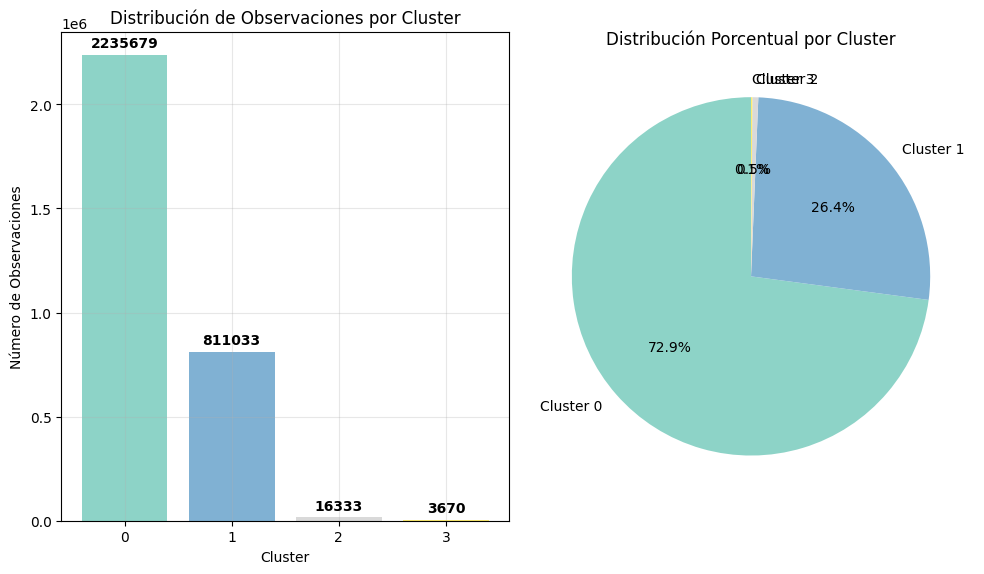

✅ Visualizaciones completadas!


In [100]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_c4,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

4 grupos totalmente separados, PC1 obtiene más del 95% de la varianza.

1 grupo mayoritario, 2 muy minoritarios y otro intermedio. Hay que tener en cuenta que son dos variables de 2 valores cada una, los 4 grupos que se obtienen son las 4 combinaciones de los 2 valores de cada variable. El grupo mayoritario serían los valores 0-0, el intermedio 0-1, y los minoritarios 1-0 y 1-1.

Esto indica que lo habitual es que los datos no se almacenen en el vehículo antes de enviarse (grupos mayoritario e intermedio), y que predomina uno de los dos proveedores de taxi existentes.

In [101]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [102]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c4_variables_técnica__silver_transformations_pca_20251111_100544.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [103]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/c4_variables_técnica__silver_logs_20251111_100546.parquet
  Total de registros en log: 1


In [104]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.61 GB / 13.61 GB (51.1%)
[Inicio] Disco usado: 42.54 GB / 115.66 GB (36.8%)


[Final] Memoria usada: 6.61 GB / 13.61 GB (51.1%)
[Final] Disco usado: 42.54 GB / 115.66 GB (36.8%)



In [105]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.61 GB / 13.61 GB (51.1%)
[Inicio limpieza completa de memoria] Disco usado: 42.54 GB / 115.66 GB (36.8%)


[Final limpieza completa de memoria] Memoria usada: 2.48 GB / 13.61 GB (20.7%)
[Final limpieza completa de memoria] Disco usado: 42.54 GB / 115.66 GB (36.8%)



### **Grupo C-5: Correlaciones cruzadas contextuales entre ubicaciones y variables tarifarias**

**C-5-1. Zona de recogida y código de tarifa**

In [106]:
grupo_c51 = [
    "PULocationID_encoded",
    "RatecodeID_encoded"
]

grupo_nombre = "C51 Zona de recogida y código de tarifa"

In [107]:
# gestión de metadatos
params = {
    "features": grupo_c51,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "C51 Zona de recogida y c\u00f3digo de tarifa",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "PULocationID_encoded",
      "RatecodeID_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-11T10:05:56.793764",
  "model_version": "7e72e381b2a1",
  "featureset_version": "C51 Zona de recogida y c\u00f3digo de tarifa_7e72e381b2a1",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [108]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_c51,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c51_zona_de_recogida__silver_features_20251111_100557.parquet
  Registros: 3,066,715
  Columnas: 7


In [109]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_c51,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - C51 ZONA DE RECOGIDA Y CÓDIGO DE TARIFA
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - C51 Zona de recogida y código de tarifa
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.137
Correlación máxima: 0.137
Correlación mínima: 0.137
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


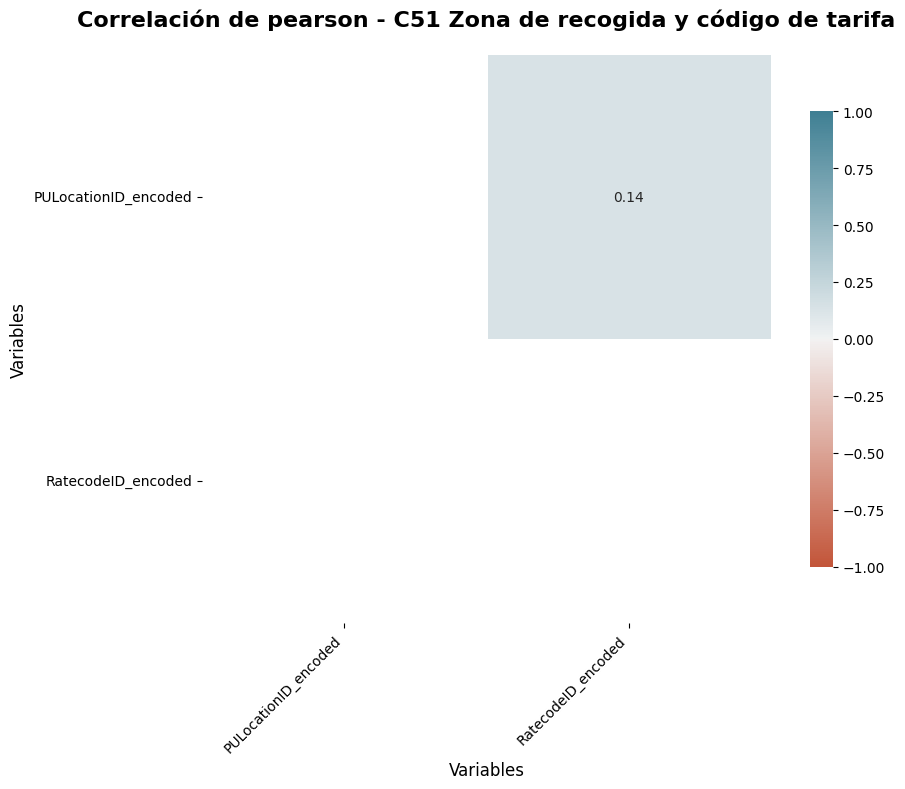


📊 ANÁLISIS DE CORRELACIÓN - C51 ZONA DE RECOGIDA Y CÓDIGO DE TARIFA
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - C51 Zona de recogida y código de tarifa
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: -0.138
Correlación máxima: -0.138
Correlación mínima: -0.138
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


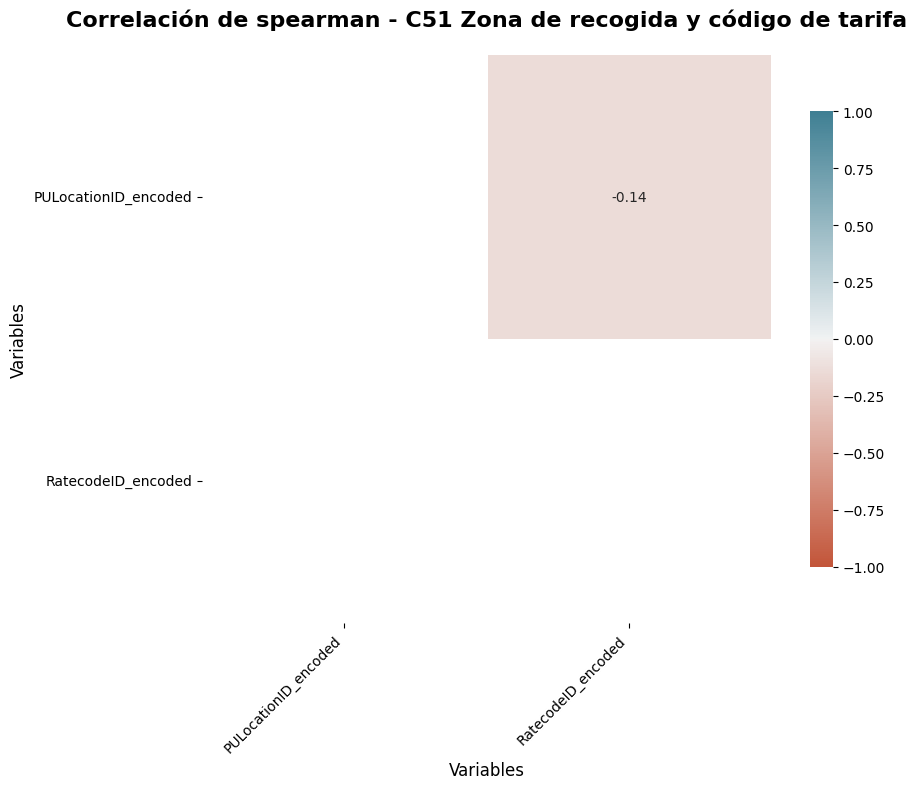

In [110]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c51,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c51,
    group_name = grupo_nombre,
    method = "spearman"
)

No hay correlación entre estas variables.

In [111]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [112]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
	  spark=spark,
    format="json",
	  group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "C51 Zona de recogida y c\u00f3digo de tarifa",
  "total_rows": 3066715,
  "variables": {
    "PULocationID_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 256.0,
      "mean": 17.559552811395907,
      "median": 14.0,
      "std": 17.18371882298674,
      "q25": 5.0,
      "q75": 26.0,
      "n_outliers_iqr": 323141
    },
    "RatecodeID_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 6.0,
      "mean": 0.07869006412398935,
      "median": 0.0,
      "std": 0.41416143459854815,
      "q25": 0.0,
      "q75": 0.0,
      "n_outliers_iqr": 155705
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_correlation": 0.13710238238310965,
        "max_correlation": 0.13710238238310965,
        "min_correlation": 0.13710238238310965,
        "std_correlation": 0.0,
    

- **Análisis de VIF**

In [113]:
analyze_vif(ds_for_correlation_clean, grupo_c51)

               Variable     VIF    Interpretacion
0  PULocationID_encoded  1.0192  Baja correlación
1    RatecodeID_encoded  1.0192  Baja correlación

=== Variables con VIF aceptable ===



['PULocationID_encoded', 'RatecodeID_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

VIF confirma que no hay correlación.

- **Clustering**

Para k = 2, la silueta media es: 0.7169
Para k = 3, la silueta media es: 0.7668
Para k = 4, la silueta media es: 0.7418
Para k = 5, la silueta media es: 0.7353
Para k = 6, la silueta media es: 0.7132
Para k = 7, la silueta media es: 0.7216
Para k = 8, la silueta media es: 0.7293


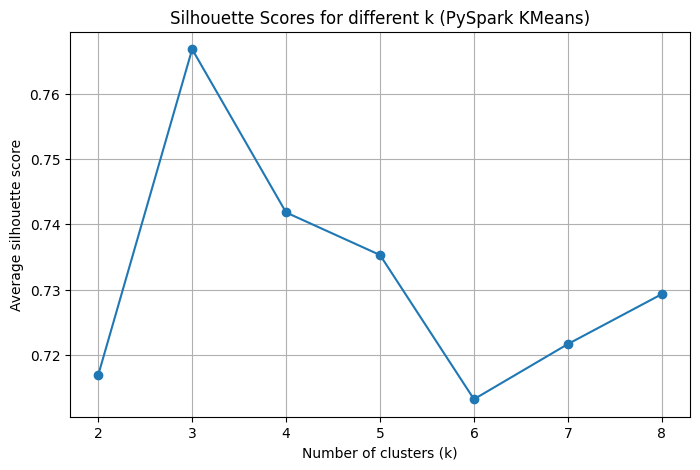

In [114]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_c51, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [115]:
k_optimo = 3

In [116]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_c51,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 3
- Variables utilizadas: ['PULocationID_encoded', 'RatecodeID_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 223031618.8517

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |1084281|
|1      |1946987|
|2      |35447  |
+-------+-------+


⏱️ Tiempo de ejecución: 68.97 segundos
📊 Balance de clusters - Min: 35447,  Max: 1946987, Std: 781615.11


In [117]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 3,
  "silhouette_score": 0.7668449450089878,
  "wssse": 223031618.8517019,
  "cluster_sizes": [
    [
      1,
      1946987
    ],
    [
      2,
      35447
    ],
    [
      0,
      1084281
    ]
  ],
  "silhouette_all_k": {
    "2": 0.7168791842144173,
    "3": 0.7668449450089878,
    "4": 0.7418138143234727,
    "5": 0.7352880202398021,
    "6": 0.7131759584517298,
    "7": 0.7216373489481532,
    "8": 0.7292933808834067
  },
  "centers": [
    [
      31.742721674547465,
      0.04294182043215735
    ],
    [
      8.02066115490242,
      0.07943042249383277
    ],
    [
      107.65342624199509,
      1.131520297909555
    ]
  ]
}


In [118]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/c51_zona_de_recogida__silver_clusters_20251111_102148.parquet
  Registros: 3,066,715
  Clusters únicos: 3


- **Reducción de dimensionalidad**

In [119]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_c51, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [120]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


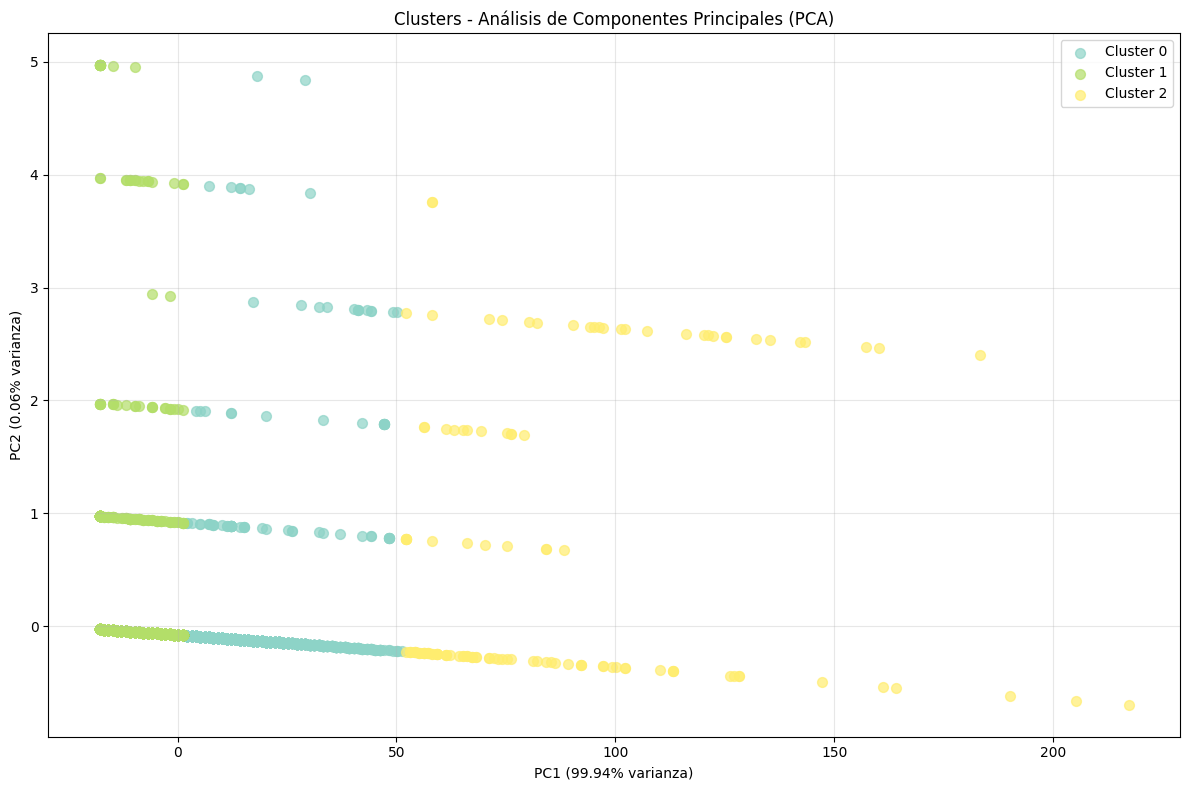

2. Perfiles de clusters...


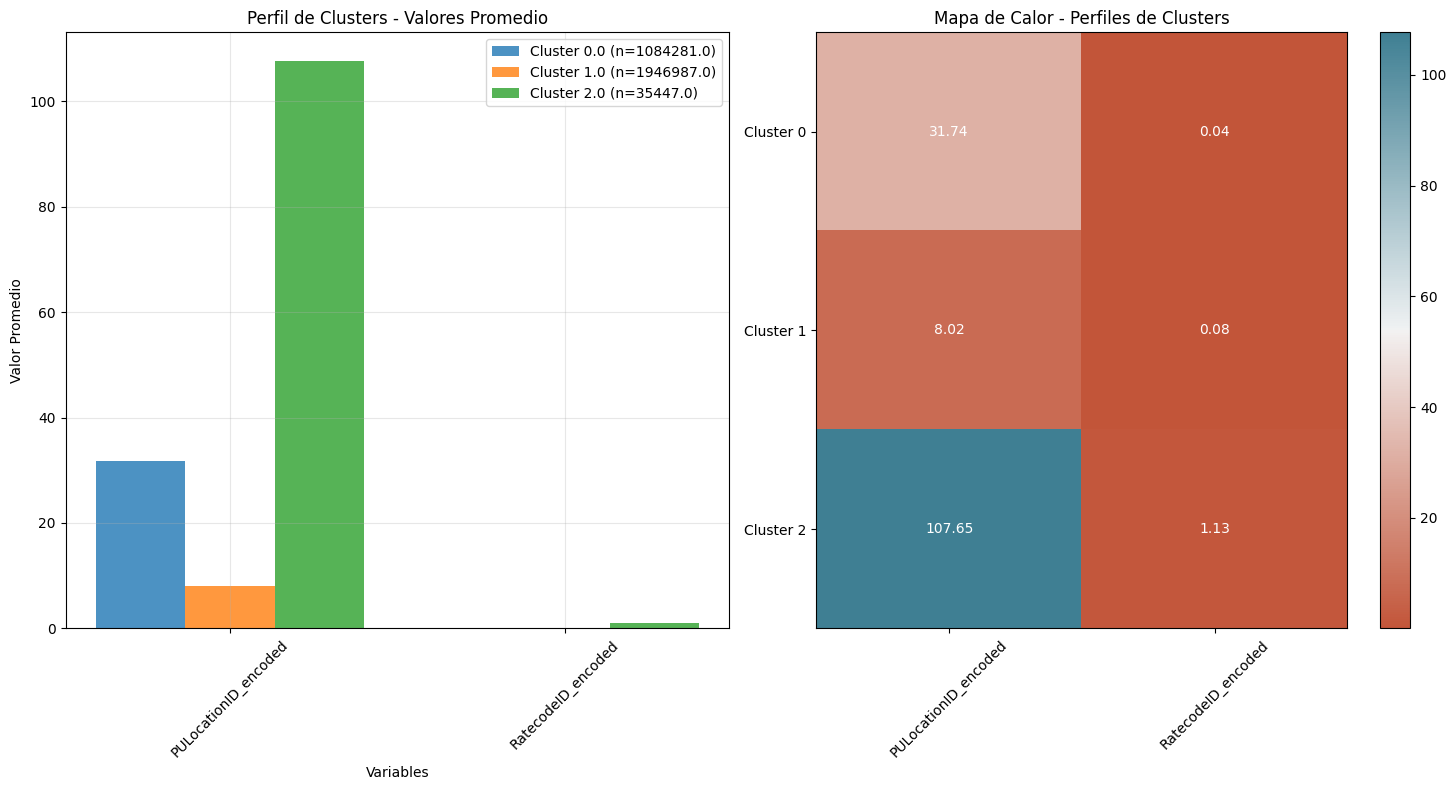

3. Distribución de clusters...


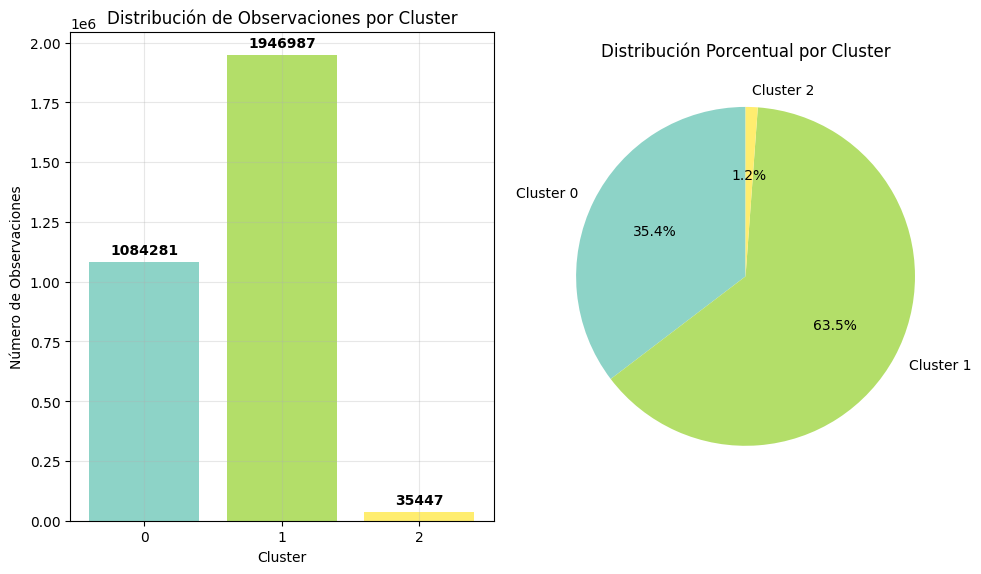

✅ Visualizaciones completadas!


In [121]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_c51,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

Grupos bien separados, PC1 obtiene casi el 100% de la varianza.

Un cluster mayoritario, uno minoritario y otro intermedio. El minoritario tiene valores elevados en la localización, el mayoritario valores bajos, el tercero tiene valores intermedios. En cuanto a la tarifa, no hay mucha variación entre los grupos mayoritario e intermedio, y es mucho mayor en el minoritario.

El grupo mayoritario serían viajes urbanos céntricos, el minoritario viajes más alejados del centro, y el otro grupo viajes intermedios.

In [122]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [123]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c51_zona_de_recogida__silver_transformations_pca_20251111_102550.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [124]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/c51_zona_de_recogida__silver_logs_20251111_102554.parquet
  Total de registros en log: 1


In [125]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.45 GB / 13.61 GB (49.9%)
[Inicio] Disco usado: 42.57 GB / 115.66 GB (36.8%)


[Final] Memoria usada: 6.45 GB / 13.61 GB (49.9%)
[Final] Disco usado: 42.57 GB / 115.66 GB (36.8%)



In [126]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.45 GB / 13.61 GB (49.9%)
[Inicio limpieza completa de memoria] Disco usado: 42.57 GB / 115.66 GB (36.8%)


[Final limpieza completa de memoria] Memoria usada: 2.50 GB / 13.61 GB (20.9%)
[Final limpieza completa de memoria] Disco usado: 42.57 GB / 115.66 GB (36.8%)



**C-5-2. Zona de llegada y código de tarifa**

In [127]:
grupo_c52 = [
    "DOLocationID_encoded",
    "RatecodeID_encoded"
]

grupo_nombre = "C52 Zona de llegada y código de tarifa"

In [128]:
# gestión de metadatos
params = {
    "features": grupo_c52,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "C52 Zona de llegada y c\u00f3digo de tarifa",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "DOLocationID_encoded",
      "RatecodeID_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-11T10:25:58.711538",
  "model_version": "e7c35818f91a",
  "featureset_version": "C52 Zona de llegada y c\u00f3digo de tarifa_e7c35818f91a",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [129]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_c52,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c52_zona_de_llegada___silver_features_20251111_102559.parquet
  Registros: 3,066,715
  Columnas: 7


In [130]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_c52,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - C52 ZONA DE LLEGADA Y CÓDIGO DE TARIFA
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - C52 Zona de llegada y código de tarifa
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.162
Correlación máxima: 0.162
Correlación mínima: 0.162
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


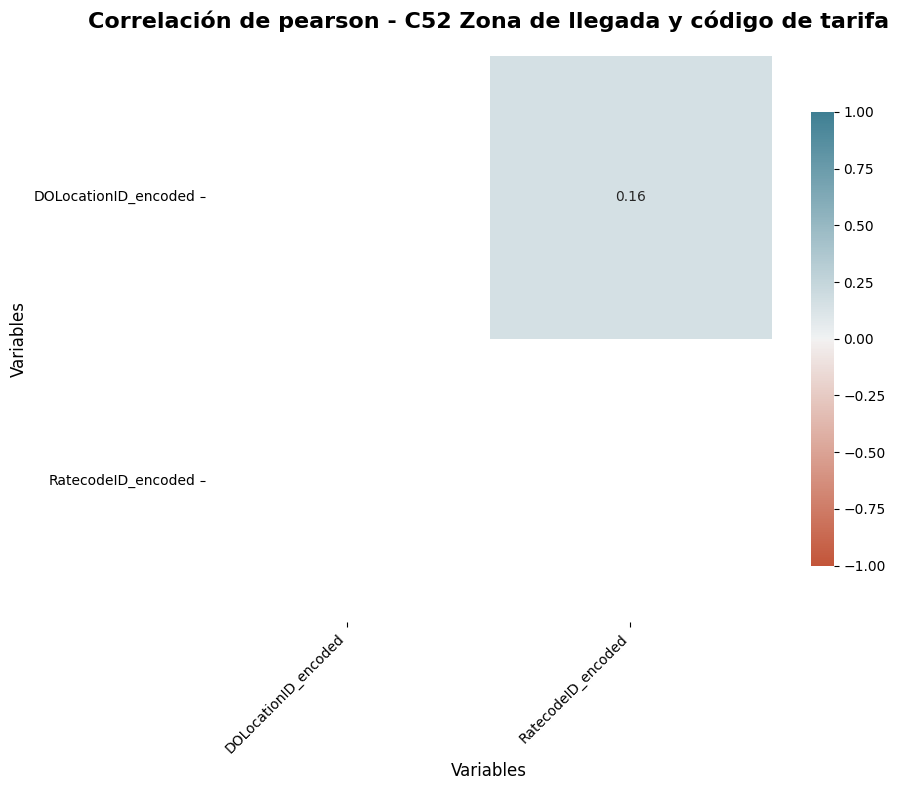


📊 ANÁLISIS DE CORRELACIÓN - C52 ZONA DE LLEGADA Y CÓDIGO DE TARIFA
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - C52 Zona de llegada y código de tarifa
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.105
Correlación máxima: 0.105
Correlación mínima: 0.105
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


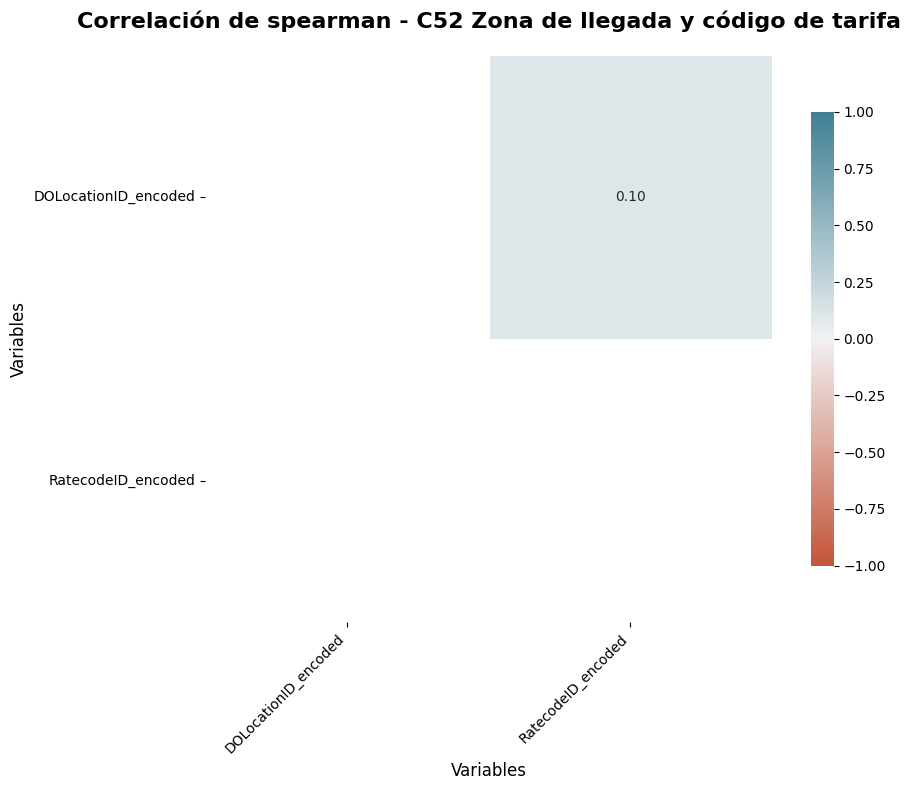

In [131]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c52,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c52,
    group_name = grupo_nombre,
    method = "spearman"
)

Sin correlación entre estas variables.

In [132]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [133]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
	  spark=spark,
    format="json",
	  group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "C52 Zona de llegada y c\u00f3digo de tarifa",
  "total_rows": 3066715,
  "variables": {
    "DOLocationID_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 260.0,
      "mean": 25.027602173661393,
      "median": 18.0,
      "std": 28.40529652147174,
      "q25": 7.0,
      "q75": 33.0,
      "n_outliers_iqr": 417225
    },
    "RatecodeID_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 6.0,
      "mean": 0.07869006412398935,
      "median": 0.0,
      "std": 0.41416143459854815,
      "q25": 0.0,
      "q75": 0.0,
      "n_outliers_iqr": 155705
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_correlation": 0.16155359662053043,
        "max_correlation": 0.16155359662053043,
        "min_correlation": 0.16155359662053043,
        "std_correlation": 0.0,
     

- **Análisis de VIF**

In [134]:
analyze_vif(ds_for_correlation_clean, grupo_c52)

               Variable     VIF    Interpretacion
0  DOLocationID_encoded  1.0268  Baja correlación
1    RatecodeID_encoded  1.0268  Baja correlación

=== Variables con VIF aceptable ===



['DOLocationID_encoded', 'RatecodeID_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

VIF confirma que no hay correlación entre estas variables.

- **Clustering**

Para k = 2, la silueta media es: 0.8609
Para k = 3, la silueta media es: 0.7814
Para k = 4, la silueta media es: 0.7676
Para k = 5, la silueta media es: 0.7445
Para k = 6, la silueta media es: 0.7344
Para k = 7, la silueta media es: 0.7017
Para k = 8, la silueta media es: 0.6984


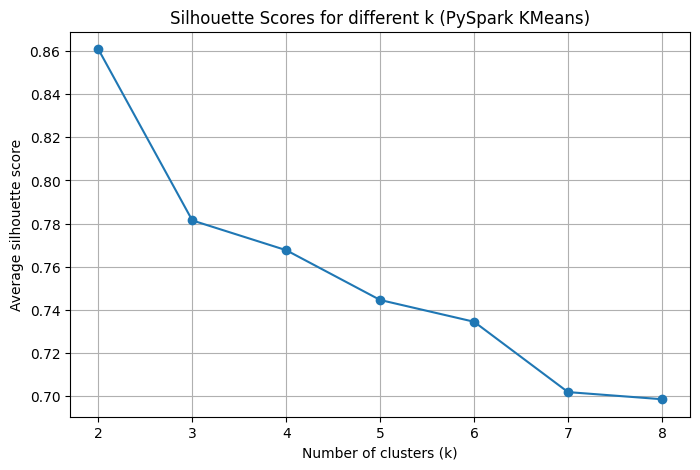

In [135]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_c52, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [136]:
k_optimo = 2

In [137]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_c52,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 2
- Variables utilizadas: ['DOLocationID_encoded', 'RatecodeID_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 993472463.6012

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |2721102|
|1      |345613 |
+-------+-------+


⏱️ Tiempo de ejecución: 64.74 segundos
📊 Balance de clusters - Min: 345613,  Max: 2721102, Std: 1187744.50


In [138]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 2,
  "silhouette_score": 0.8609132325447746,
  "wssse": 993472463.6011745,
  "cluster_sizes": [
    [
      1,
      345613
    ],
    [
      0,
      2721102
    ]
  ],
  "silhouette_all_k": {
    "2": 0.8609132325447746,
    "3": 0.7814350073356838,
    "4": 0.7676084643338236,
    "5": 0.7444924888191737,
    "6": 0.734378850623236,
    "7": 0.7017283206080774,
    "8": 0.6984207703964662
  },
  "centers": [
    [
      17.194588442476615,
      0.050867993923050296
    ],
    [
      86.69897833704171,
      0.2977405363802866
    ]
  ]
}


In [139]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/c52_zona_de_llegada___silver_clusters_20251111_104053.parquet
  Registros: 3,066,715
  Clusters únicos: 2


- **Reducción de dimensionalidad**

In [140]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_c52, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [141]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


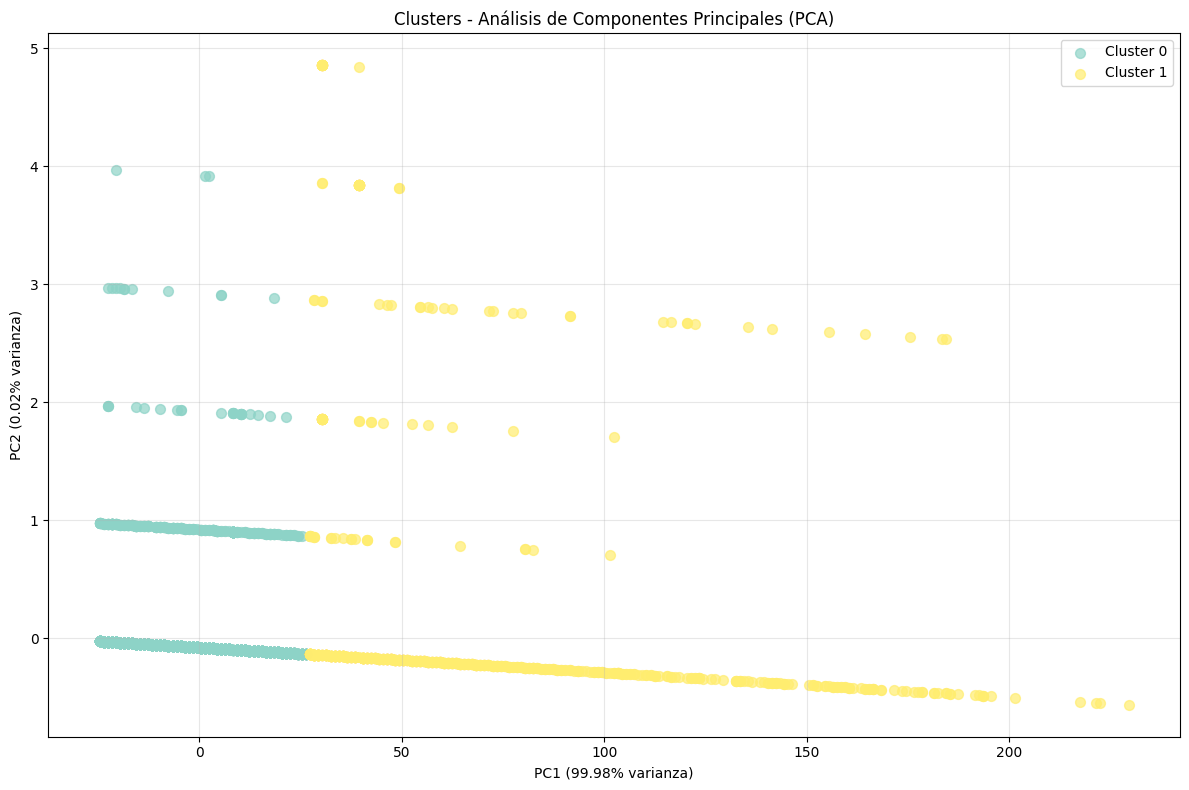

2. Perfiles de clusters...


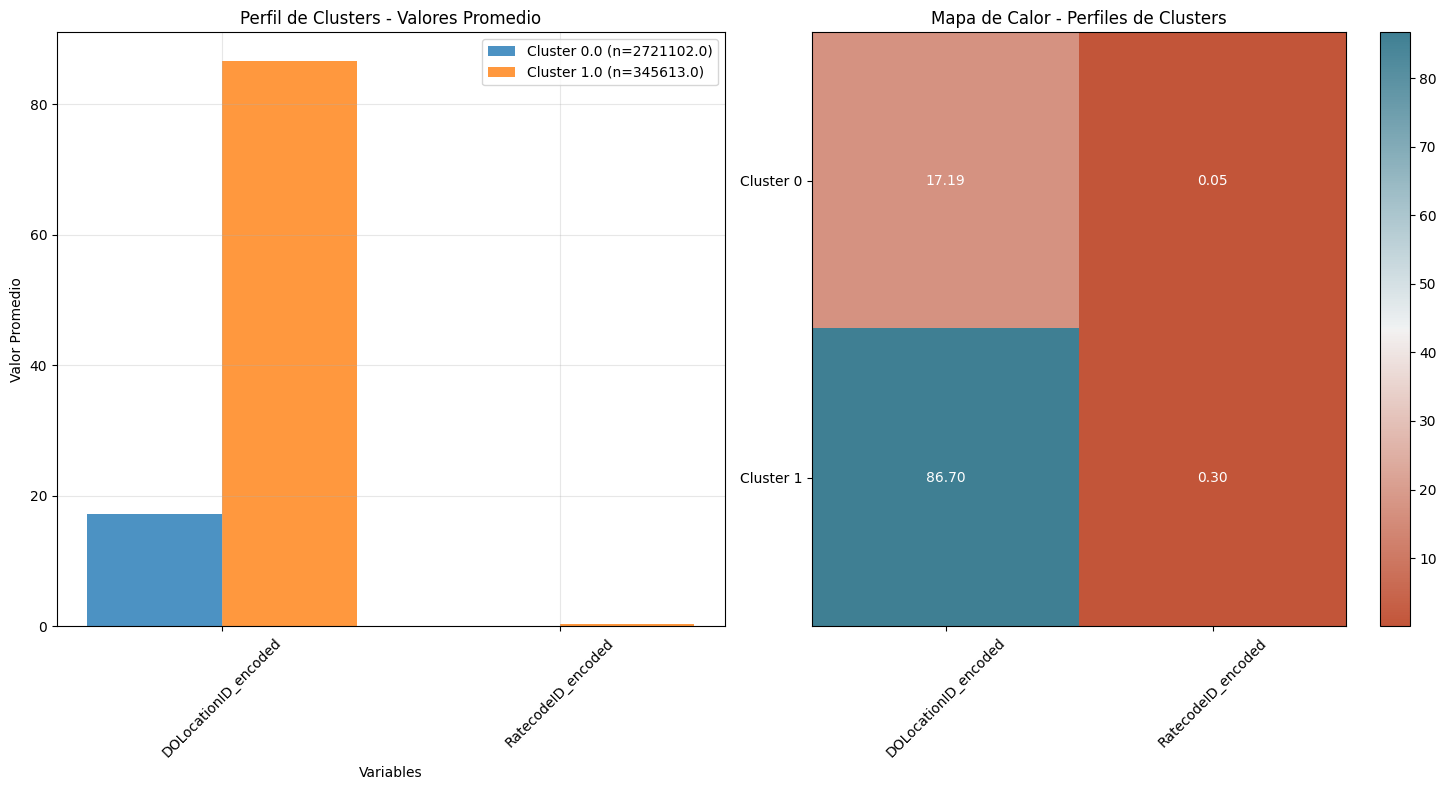

3. Distribución de clusters...


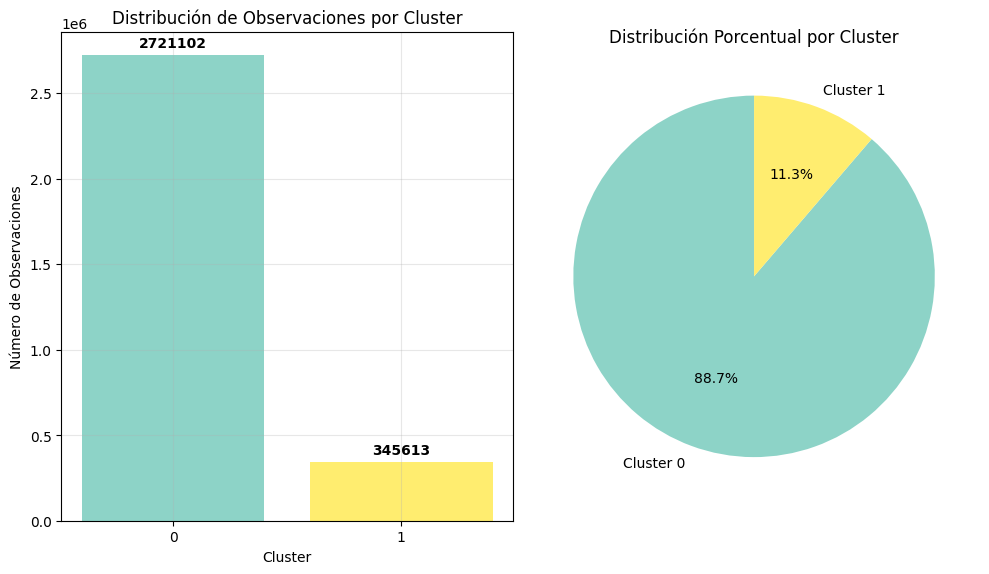

✅ Visualizaciones completadas!


In [142]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_c52,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

2 grupos bien definidos, PC1 obtiene casi el 100% de la varianza.

Un grupo mayoritario, valores de ubicación mucho más bajos que el otro grupo, poca variación entre ellos en el tipo de tarifa.

Similar al caso anterior, el de la zona de recogida; aquí se distinguen dos zonas de llegada, una céntrica, la mayoritaria, y otra alejada del centro, menos habitual.

In [143]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [144]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c52_zona_de_llegada___silver_transformations_pca_20251111_104146.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [145]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/c52_zona_de_llegada___silver_logs_20251111_104148.parquet
  Total de registros en log: 1


In [146]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.68 GB / 13.61 GB (51.6%)
[Inicio] Disco usado: 42.60 GB / 115.66 GB (36.8%)


[Final] Memoria usada: 6.68 GB / 13.61 GB (51.6%)
[Final] Disco usado: 42.60 GB / 115.66 GB (36.8%)



In [147]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.68 GB / 13.61 GB (51.6%)
[Inicio limpieza completa de memoria] Disco usado: 42.60 GB / 115.66 GB (36.8%)


[Final limpieza completa de memoria] Memoria usada: 2.53 GB / 13.61 GB (21.1%)
[Final limpieza completa de memoria] Disco usado: 42.60 GB / 115.66 GB (36.8%)



**C-5-3. Zona de recogida y tarifa por milla**

In [148]:
grupo_c53 = [
    "PULocationID_encoded",
    "fare_per_mile_encoded"
]

grupo_nombre = "C53 Zona de recogida y tarifa por milla"

In [149]:
# gestión de metadatos
params = {
    "features": grupo_c53,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "C53 Zona de recogida y tarifa por milla",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "PULocationID_encoded",
      "fare_per_mile_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-11T10:41:51.776316",
  "model_version": "545d2468acdc",
  "featureset_version": "C53 Zona de recogida y tarifa por milla_545d2468acdc",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [150]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_c53,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c53_zona_de_recogida__silver_features_20251111_104152.parquet
  Registros: 3,066,715
  Columnas: 7


In [151]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_c53,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - C53 ZONA DE RECOGIDA Y TARIFA POR MILLA
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - C53 Zona de recogida y tarifa por milla
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: -0.030
Correlación máxima: -0.030
Correlación mínima: -0.030
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


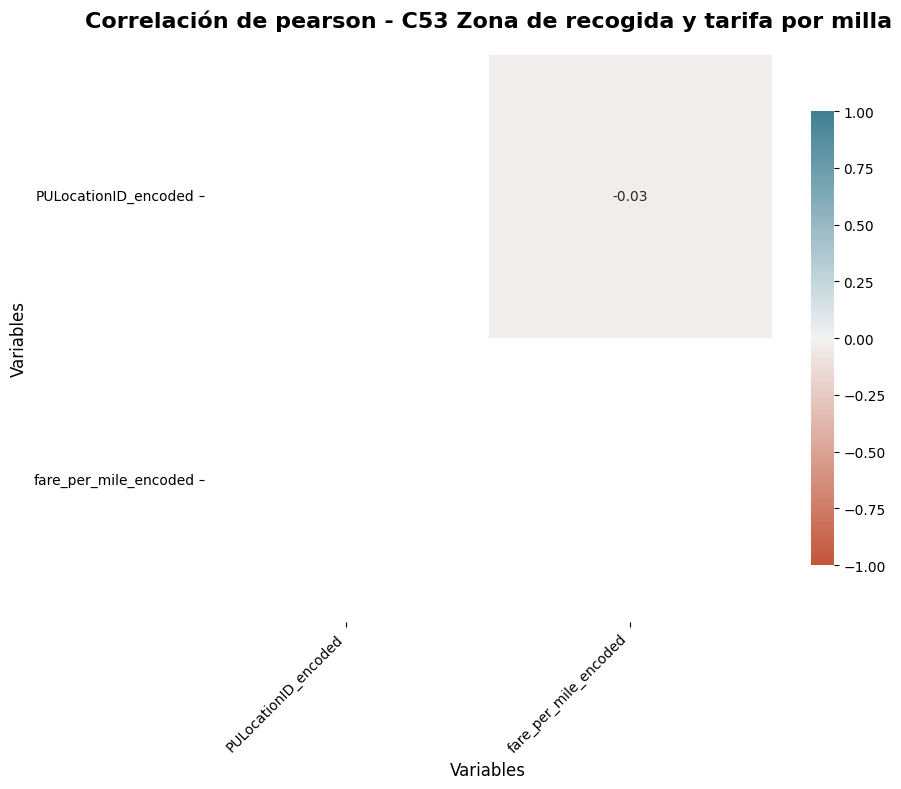


📊 ANÁLISIS DE CORRELACIÓN - C53 ZONA DE RECOGIDA Y TARIFA POR MILLA
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - C53 Zona de recogida y tarifa por milla
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.031
Correlación máxima: 0.031
Correlación mínima: 0.031
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


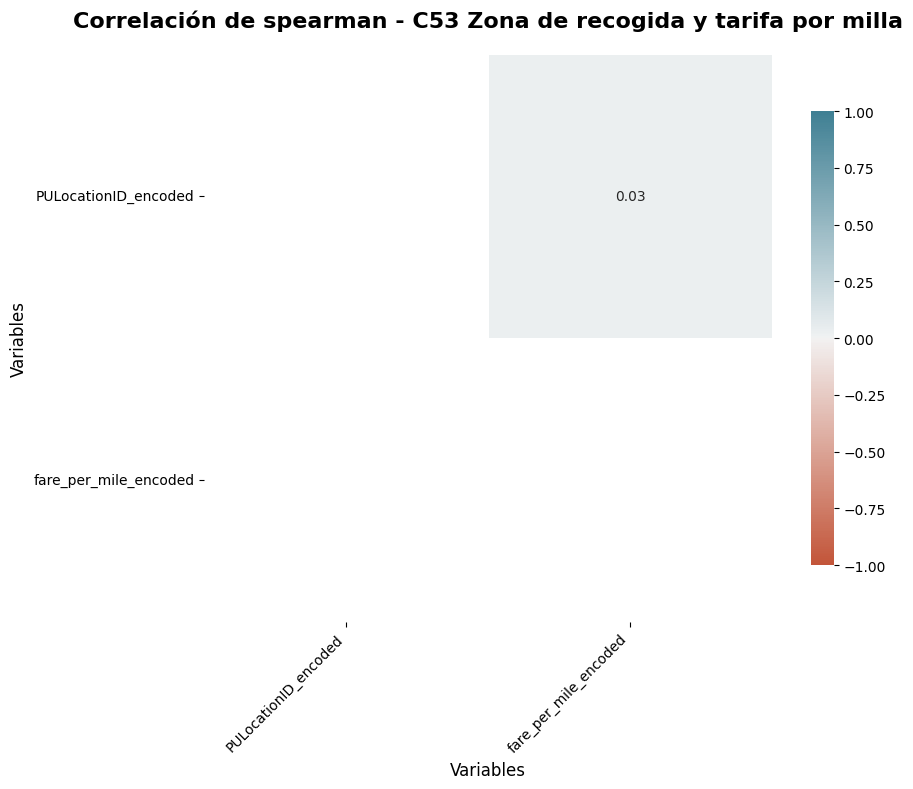

In [152]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c53,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c53,
    group_name = grupo_nombre,
    method = "spearman"
)

Variables sin correlación.

In [153]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [154]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
	  spark=spark,
    format="json",
	  group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "C53 Zona de recogida y tarifa por milla",
  "total_rows": 3066715,
  "variables": {
    "PULocationID_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 256.0,
      "mean": 17.559552811395907,
      "median": 14.0,
      "std": 17.18371882298674,
      "q25": 5.0,
      "q75": 26.0,
      "n_outliers_iqr": 323141
    },
    "fare_per_mile_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -2.868975336736538,
      "max": 5.070273271175834,
      "mean": -1.3034152065937163e-13,
      "median": -0.1696446217696298,
      "std": 0.9999999999999712,
      "q25": -0.6920997782509958,
      "q75": 0.4871494942882729,
      "n_outliers_iqr": 390137
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_correlation": -0.02952027828644413,
        "max_correlation": -0.02952027828644413,
     

- **Análisis de VIF**

In [155]:
analyze_vif(ds_for_correlation_clean, grupo_c53)

                Variable     VIF    Interpretacion
0   PULocationID_encoded  1.0009  Baja correlación
1  fare_per_mile_encoded  1.0009  Baja correlación

=== Variables con VIF aceptable ===



['PULocationID_encoded', 'fare_per_mile_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

VIF confirma la fata de correlación.

- **Clustering**

Para k = 2, la silueta media es: 0.7158
Para k = 3, la silueta media es: 0.7646
Para k = 4, la silueta media es: 0.7376
Para k = 5, la silueta media es: 0.7288
Para k = 6, la silueta media es: 0.7046
Para k = 7, la silueta media es: 0.7132
Para k = 8, la silueta media es: 0.7185


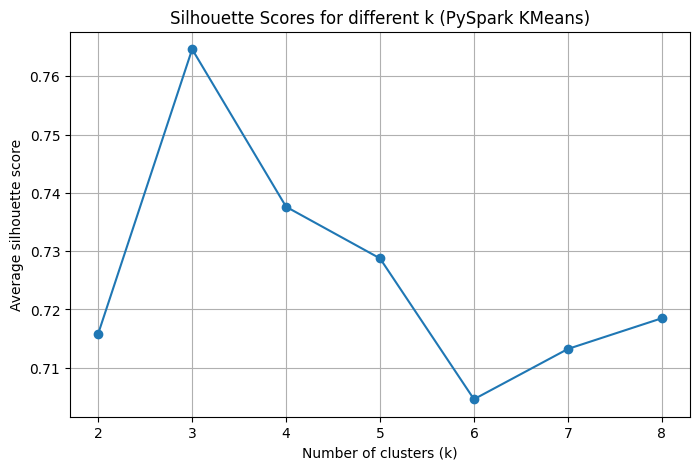

In [156]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_c53, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [157]:
k_optimo = 3

In [158]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_c53,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 3
- Variables utilizadas: ['PULocationID_encoded', 'fare_per_mile_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 225609046.4971

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |1084281|
|1      |1946987|
|2      |35447  |
+-------+-------+


⏱️ Tiempo de ejecución: 64.21 segundos
📊 Balance de clusters - Min: 35447,  Max: 1946987, Std: 781615.11


In [159]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 3,
  "silhouette_score": 0.7646448162042191,
  "wssse": 225609046.49714994,
  "cluster_sizes": [
    [
      1,
      1946987
    ],
    [
      2,
      35447
    ],
    [
      0,
      1084281
    ]
  ],
  "silhouette_all_k": {
    "2": 0.7158442175638079,
    "3": 0.7646448162042191,
    "4": 0.7376149564607085,
    "5": 0.7287534370581598,
    "6": 0.704594316364688,
    "7": 0.7132202996365428,
    "8": 0.7184876728455676
  },
  "centers": [
    [
      31.742721674547465,
      -0.005434216999478021
    ],
    [
      8.02066115490242,
      0.008943300400220795
    ],
    [
      107.65342624199509,
      -0.3249998977128373
    ]
  ]
}


In [160]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/c53_zona_de_recogida__silver_clusters_20251111_105646.parquet
  Registros: 3,066,715
  Clusters únicos: 3


- **Reducción de dimensionalidad**

In [161]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_c53, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [162]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


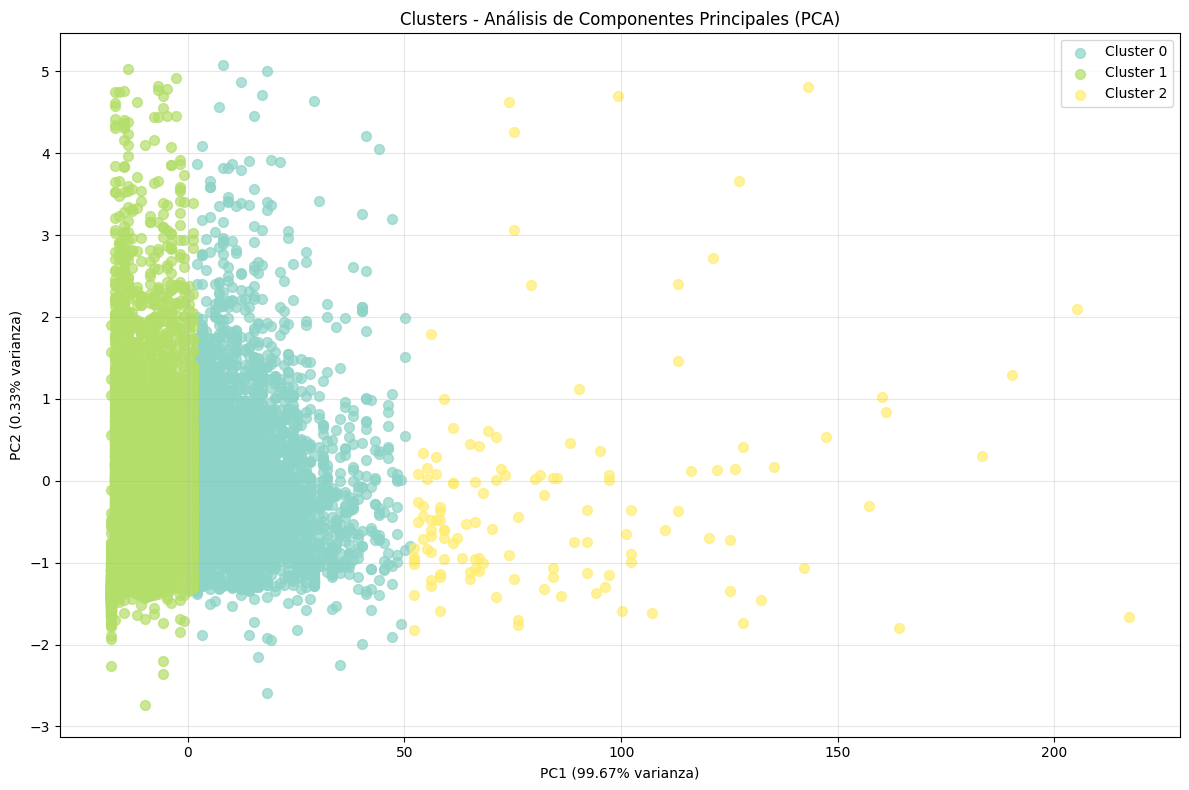

2. Perfiles de clusters...


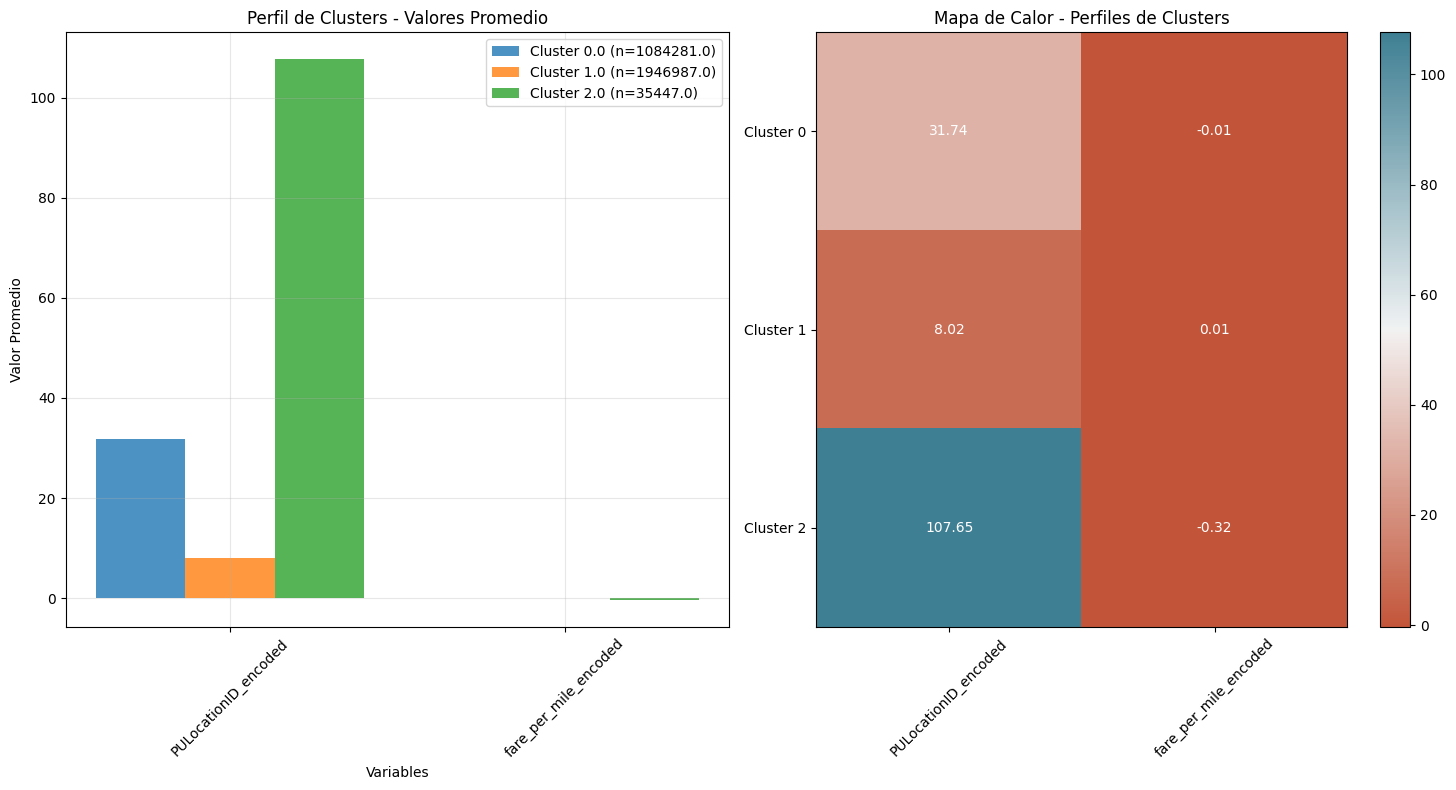

3. Distribución de clusters...


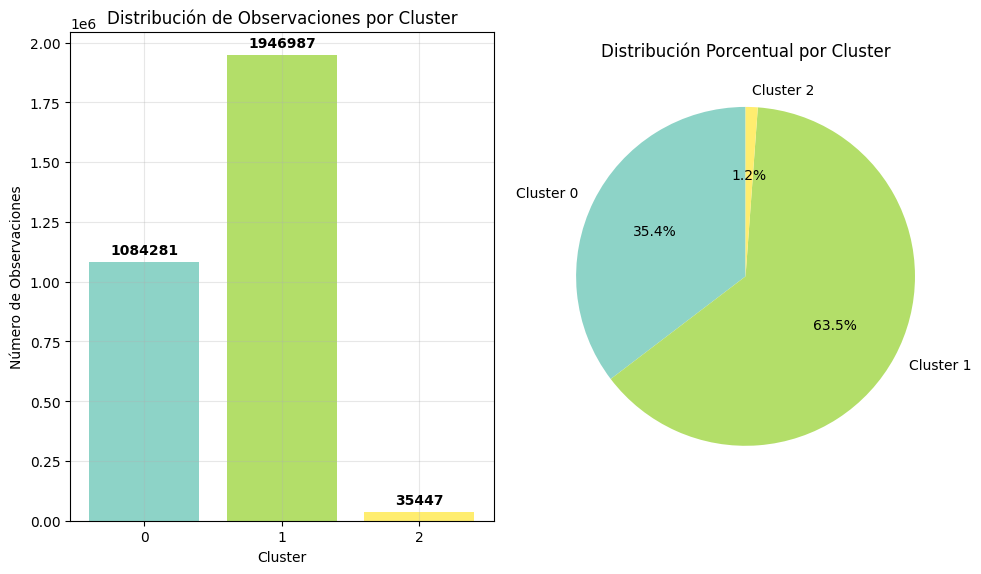

✅ Visualizaciones completadas!


In [163]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_c53,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

3 grupos bien definidos, la PC1 obtiene casi el 100% de la varianza.

Un grupo mayoritario, otro minoritario y un tercero intermedio. El mayoritario,
zonas de origen céntricas; el minoritario, zonas alejadas del centro; el tercer grupo, zonas intermedias. Tarifa por milla más elevada para el grupo minoritario.

In [164]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [165]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c53_zona_de_recogida__silver_transformations_pca_20251111_110127.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [166]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/c53_zona_de_recogida__silver_logs_20251111_110129.parquet
  Total de registros en log: 1


In [167]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.49 GB / 13.61 GB (50.2%)
[Inicio] Disco usado: 42.64 GB / 115.66 GB (36.9%)


[Final] Memoria usada: 6.49 GB / 13.61 GB (50.2%)
[Final] Disco usado: 42.64 GB / 115.66 GB (36.9%)



In [168]:
# limpieza completa de memoria
clear_all_caches(spark)


[Inicio limpieza completa de memoria] Memoria usada: 6.49 GB / 13.61 GB (50.2%)
[Inicio limpieza completa de memoria] Disco usado: 42.64 GB / 115.66 GB (36.9%)


[Final limpieza completa de memoria] Memoria usada: 2.54 GB / 13.61 GB (21.1%)
[Final limpieza completa de memoria] Disco usado: 42.64 GB / 115.66 GB (36.9%)



**C-5-4. Zona de llegada y cargos adicionales**

In [169]:
grupo_c54 = [
    "DOLocationID_encoded",
    "extra_encoded"
]

grupo_nombre = "C54 Zona de llegada y cargos adicionales"

In [170]:
# gestión de metadatos
params = {
    "features": grupo_c54,
    "analysis_type": ["pearson", "spearman", "vif"],
    "vif_thresold": 10
}

metadata = generate_metadata(
    group_name=grupo_nombre,
    model_type="correlation",
    row_count=ds_for_correlation_clean.count(),
    parameters=params,
    spark=spark
)

print(json.dumps(metadata, indent=2))

{
  "group_name": "C54 Zona de llegada y cargos adicionales",
  "model_type": "correlation",
  "row_count": 3066715,
  "parameters": {
    "features": [
      "DOLocationID_encoded",
      "extra_encoded"
    ],
    "analysis_type": [
      "pearson",
      "spearman",
      "vif"
    ],
    "vif_thresold": 10
  },
  "processing_date": "2025-11-11T11:01:33.836051",
  "model_version": "7573da5a1030",
  "featureset_version": "C54 Zona de llegada y cargos adicionales_7573da5a1030",
  "python_version": "3.12.12",
  "spark_version": "3.5.1"
}


In [171]:
# guarda features
filepath_features = save_features_table(
    ds=ds_for_correlation_clean,
    trip_ids=None,
    group_name=grupo_nombre,
    feature_columns=grupo_c54,
    metadata=metadata,
    output_path=SILVER_GOLD_DIR
)

✓ Features guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c54_zona_de_llegada___silver_features_20251111_110135.parquet
  Registros: 3,066,715
  Columnas: 7


In [172]:
# métricas de calidad
quality_metrics = compute_quality_metrics(
    ds=ds_for_correlation_clean,
    feature_columns=grupo_c54,
    group_name=grupo_nombre
)

- **Matriz de correlación**


📊 ANÁLISIS DE CORRELACIÓN - C54 ZONA DE LLEGADA Y CARGOS ADICIONALES
🔄 Calculando correlaciones de pearson para 2 variables...

📈 RESUMEN ESTADÍSTICO - C54 Zona de llegada y cargos adicionales
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.025
Correlación máxima: 0.025
Correlación mínima: 0.025
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


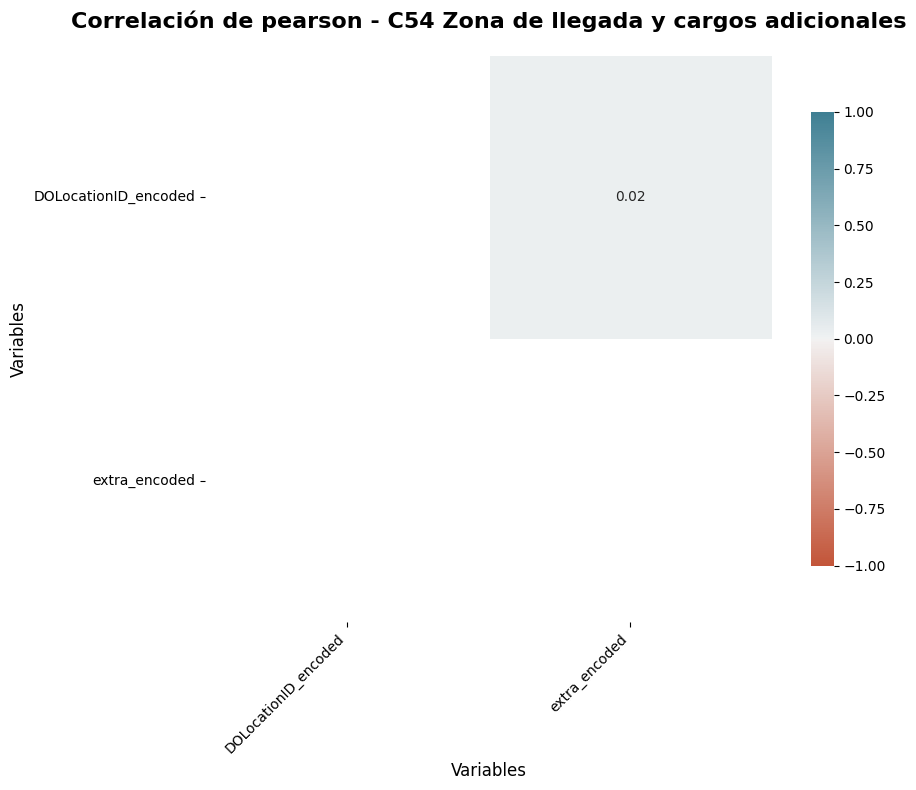


📊 ANÁLISIS DE CORRELACIÓN - C54 ZONA DE LLEGADA Y CARGOS ADICIONALES
🔄 Calculando correlaciones de spearman para 2 variables...

📈 RESUMEN ESTADÍSTICO - C54 Zona de llegada y cargos adicionales
--------------------------------------------------
Total de pares de variables: 1
Correlación promedio: 0.031
Correlación máxima: 0.031
Correlación mínima: 0.031
Desviación estándar: 0.000

🎯 DISTRIBUCIÓN DE CORRELACIONES:
Alto (|r| > 0.7): 0 pares
Moderado (0.3 < |r| ≤ 0.7): 0 pares
Bajo (|r| ≤ 0.3): 1 pares


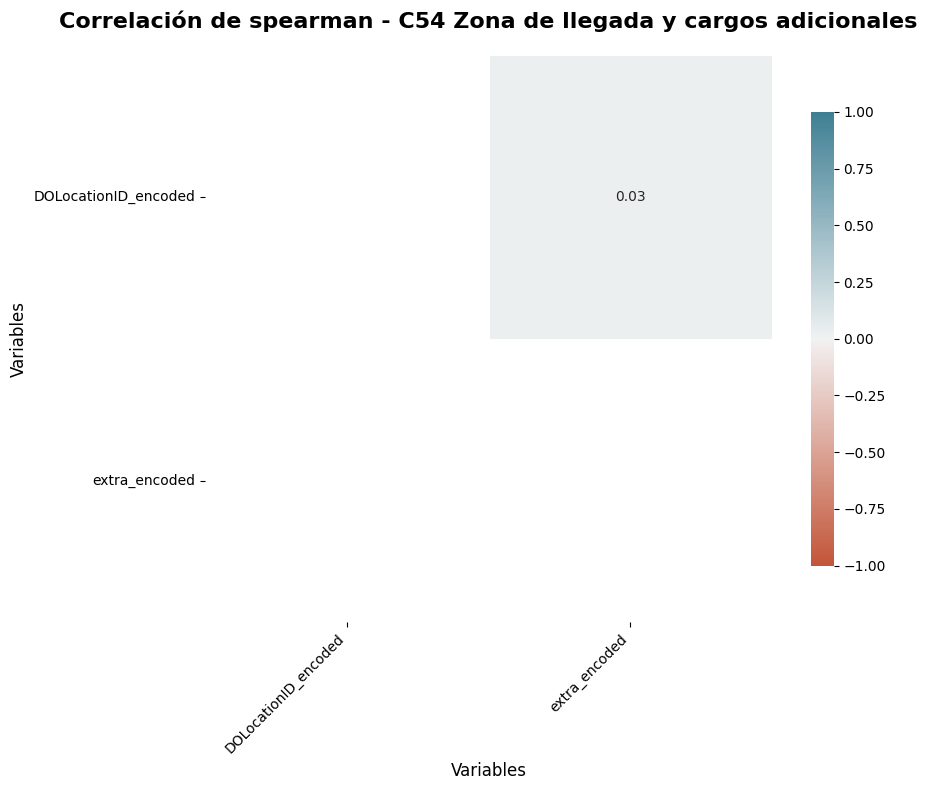

In [173]:
results_grupo_pearson = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c54,
    group_name = grupo_nombre
)

results_grupo_spearman = analyze_correlations(
    ds_spark = ds_for_correlation_clean,
    variables_list = grupo_c54,
    group_name = grupo_nombre,
    method = "spearman"
)

No hay correlación entre estas variables.

In [174]:
# añade resultados correlaciones a quality_metrics
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_pearson, "pearson", top_n=5
)
quality_metrics = attach_correlations_to_quality_metrics(
    quality_metrics, results_grupo_spearman, "spearman", top_n=5
)

In [175]:
# guarda quality metrics
persist_info = save_quality_metrics(
    quality_metrics,
    output_path=SILVER_GOLD_DIR,
	  spark=spark,
    format="json",
	  group_name=grupo_nombre
)

# añade referencia al artefacto generado
quality_metrics["correlations"]["artifact_ref"] = persist_info

# muestra métricas
print(json.dumps(quality_metrics, indent=2, default=str))

{
  "group_name": "C54 Zona de llegada y cargos adicionales",
  "total_rows": 3066715,
  "variables": {
    "DOLocationID_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": 0.0,
      "max": 260.0,
      "mean": 25.027602173661393,
      "median": 18.0,
      "std": 28.40529652147174,
      "q25": 7.0,
      "q75": 33.0,
      "n_outliers_iqr": 417225
    },
    "extra_encoded": {
      "n_nulls": 0,
      "pct_nulls": 0.0,
      "n_valid": 3066715,
      "min": -0.8743675512587032,
      "max": 6.163907903936601,
      "mean": 3.140356071285703e-14,
      "median": -0.31130551484307895,
      "std": 0.9999999999999974,
      "q25": -0.8743675512587032,
      "q75": 0.5332875397803576,
      "n_outliers_iqr": 297561
    }
  },
  "n_variables": 2,
  "correlations": {
    "pearson": {
      "summary_stats": {
        "total_pairs": 1,
        "mean_correlation": 0.02480325164541909,
        "max_correlation": 0.02480325164541909,
        "min_c

- **Análisis de VIF**

In [176]:
analyze_vif(ds_for_correlation_clean, grupo_c54)

               Variable     VIF    Interpretacion
0  DOLocationID_encoded  1.0006  Baja correlación
1         extra_encoded  1.0006  Baja correlación

=== Variables con VIF aceptable ===



['DOLocationID_encoded', 'extra_encoded']


=== Variables con VIF no aceptable (>= 10) ===



[]

VIF confirma la falta de correlación.

- **Clustering**

Para k = 2, la silueta media es: 0.8607
Para k = 3, la silueta media es: 0.7805
Para k = 4, la silueta media es: 0.7474
Para k = 5, la silueta media es: 0.7396
Para k = 6, la silueta media es: 0.7136
Para k = 7, la silueta media es: 0.7009
Para k = 8, la silueta media es: 0.7038


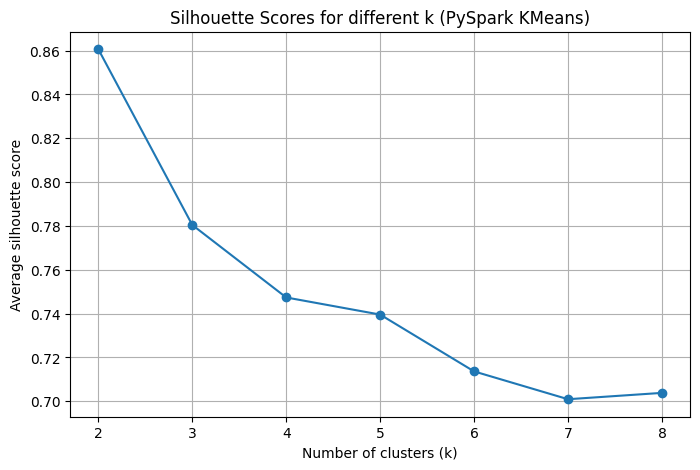

In [177]:
num_clusters_a_probar = [2, 3, 4, 5, 6, 7, 8]

scores = silhouette_score_spark(ds_for_correlation_clean, grupo_c54, num_clusters_a_probar)

plot_silhouette_scores(scores)

In [178]:
k_optimo = 2

In [179]:
# aplica K-Means
ds_con_clusters, modelo_kmeans, cluster_stats = apply_kmeans_spark(
    ds = ds_for_correlation_clean,
    variables = grupo_c54,
    k = k_optimo,
    standardize = False
)

# extrae los clusters
clusters = ds_con_clusters.select("cluster").rdd.flatMap(lambda x: x).collect()

K-Means aplicado con éxito:
- Número de clusters: 2
- Variables utilizadas: ['DOLocationID_encoded', 'extra_encoded']
- Estandarización: No
- WSSSE (Within Set Sum of Squared Errors): 996031489.6995

Distribución de clusters:
+-------+-------+
|cluster|count  |
+-------+-------+
|0      |2721102|
|1      |345613 |
+-------+-------+


⏱️ Tiempo de ejecución: 65.50 segundos
📊 Balance de clusters - Min: 345613,  Max: 2721102, Std: 1187744.50


In [180]:
# calcula métricas del modelo
model_metrics_kmeans = compute_model_metrics(
    model=modelo_kmeans,
    ds_clustered=ds_con_clusters,
    silhouette_scores=scores,
    k_optimo=k_optimo,
    metric_type="clustering"
)

# muestra métricas
print(json.dumps(model_metrics_kmeans, indent=2))

{
  "n_clusters": 2,
  "silhouette_score": 0.8606573562899028,
  "wssse": 996031489.6995423,
  "cluster_sizes": [
    [
      1,
      345613
    ],
    [
      0,
      2721102
    ]
  ],
  "silhouette_all_k": {
    "2": 0.8606573562899028,
    "3": 0.7804549110129422,
    "4": 0.7473633744190818,
    "5": 0.73955006268814,
    "6": 0.7136157269529889,
    "7": 0.7009225569374541,
    "8": 0.7038158999215374
  },
  "centers": [
    [
      17.194588442476615,
      -0.0037816634681645794
    ],
    [
      86.69897833704171,
      0.029774030567850083
    ]
  ]
}


In [181]:
# guarda clusters
filepath_clusters = save_clusters_table(
    ds_clustered=ds_con_clusters,
    trip_ids=None,
    group_name=grupo_nombre,
    model_name=f"kmeans_k{k_optimo}",
    metadata=metadata,
    model_metrics=model_metrics_kmeans,
    output_path=SILVER_GOLD_DIR
)

✓ Clusters guardados:
/content/drive/MyDrive/taxi_project/silver/for_gold/c54_zona_de_llegada___silver_clusters_20251111_113148.parquet
  Registros: 3,066,715
  Clusters únicos: 2


- **Reducción de dimensionalidad**

In [182]:
# aplica PCA
ds_pca, method_info, sample_size = calculate_dimensionality_reduction(
    ds_con_clusters, spark, grupo_c54, method="pca"
)

⚠️ Muestra de 10000 puntos de 3066715 totales
✅ Reducción de dimensionalidad completada


In [183]:
# métricas de reducción de dimensionalidad
dim_metrics = prepare_dimensionality_metrics(method_info, method='pca')

🎨 Generando visualizaciones de clusters...

1. Gráfico 2D...


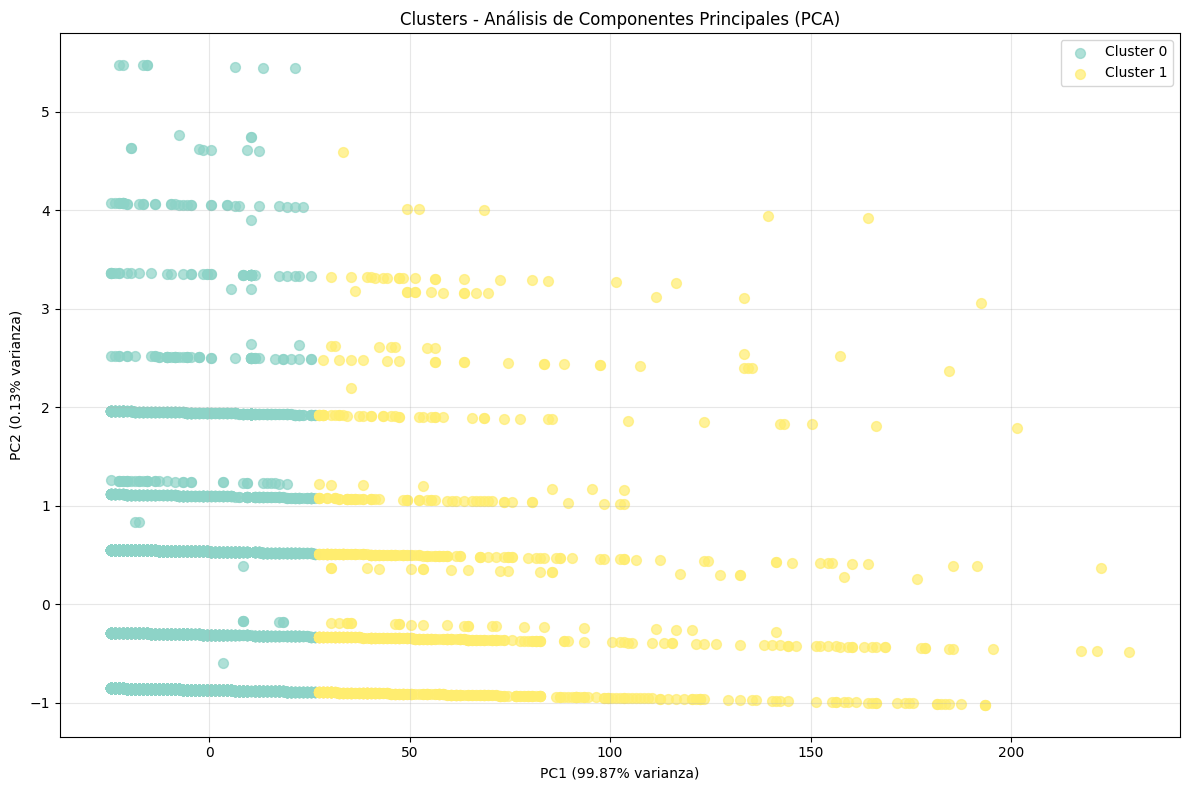

2. Perfiles de clusters...


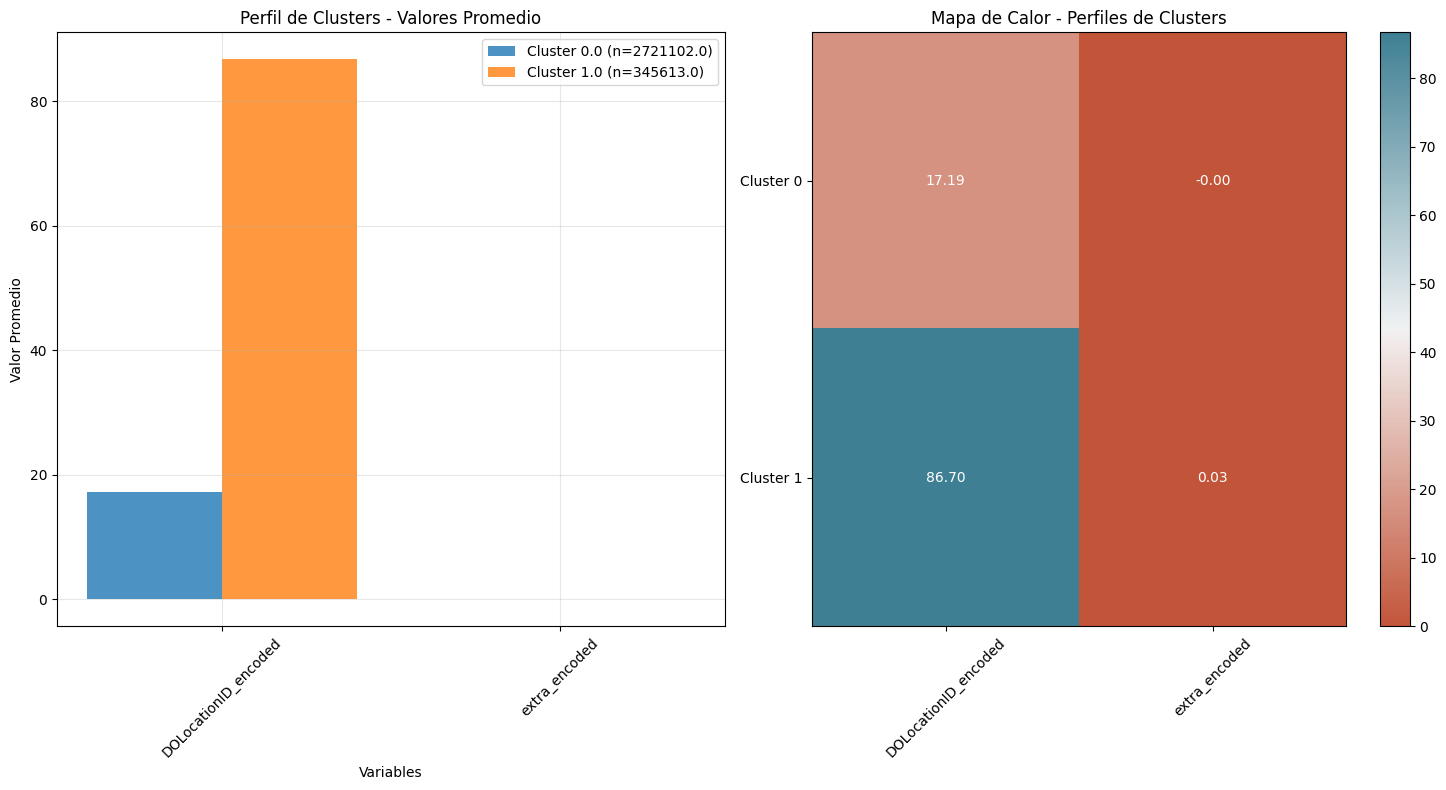

3. Distribución de clusters...


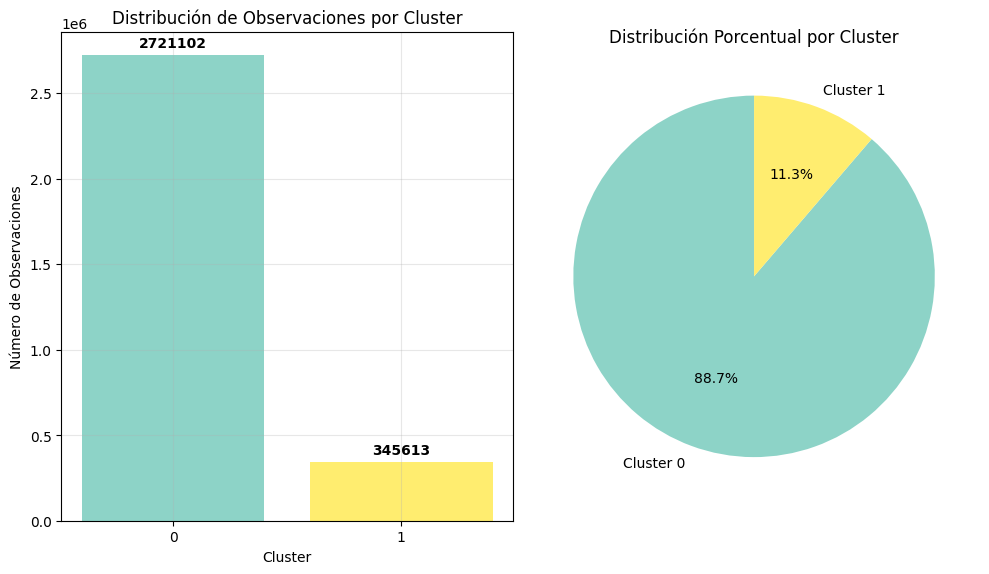

✅ Visualizaciones completadas!


In [184]:
# crea todas las visualizaciones
visualize_clusters_complete(
    ds_con_clusters,
    grupo_c54,
    save_plots=False,
    ds_result=ds_pca,
    method_info=method_info,
    sample_size=sample_size
)

2 grupos bien definidos, PC1 obtiene casi el 100% de la varianza.

Un grupo mayoritario y otro minoritario. Zonas alejadas del centro para el minoritario, zonas cercanas al centro para el mayoritario. Sin mucha diferencia en cuanto a los cargos adicionales.

In [185]:
# combina dim_metrics con model_metrics
model_metrics_kmeans.update(dim_metrics)

In [186]:
# guarda transformaciones PCA
filepath_pca = save_transformations_table(
    ds_transformed=ds_pca,
    trip_ids=None,
    group_name=grupo_nombre,
    transformation_type="pca",
    metadata=metadata,
    n_components=2,
    output_path=SILVER_GOLD_DIR
)

✓ Transformaciones guardadas:
/content/drive/MyDrive/taxi_project/silver/for_gold/c54_zona_de_llegada___silver_transformations_pca_20251111_113325.parquet
  Registros: 9,969
  Componentes: 2


- **Logging y limpieza**

In [187]:
# logging de métricas

# combina todas las métricas
combined_metrics = {
    **model_metrics_kmeans,
    **dim_metrics
}

# rutas de features, clusters y transformations
artifact_paths = {
    "features": filepath_features,
    "clusters": filepath_clusters,
    "pca": filepath_pca
}

# guarda logs
save_log_metrics(
    group_name=grupo_nombre,
    model_type="clustering_pca",
    quality_metrics=quality_metrics,
    model_metrics=combined_metrics,
    metadata=metadata,
    artifact_paths=artifact_paths,
    output_path=SILVER_GOLD_DIR
)

✓ Métricas registradas en:
/content/drive/MyDrive/taxi_project/silver/for_gold/c54_zona_de_llegada___silver_logs_20251111_113327.parquet
  Total de registros en log: 1


In [188]:
# limpieza de variables
clear_memory()


[Inicio] Memoria usada: 6.46 GB / 13.61 GB (49.9%)
[Inicio] Disco usado: 42.67 GB / 115.66 GB (36.9%)


[Final] Memoria usada: 6.46 GB / 13.61 GB (49.9%)
[Final] Disco usado: 42.67 GB / 115.66 GB (36.9%)



In [189]:
# limpia la memoria
ds_for_correlation_clean.unpersist()
ds_con_clusters.unpersist()

DataFrame[payment_type: bigint, pickup_hour: int, is_weekend: int, PULocationID_encoded: double, DOLocationID_encoded: double, passenger_count_encoded: double, RatecodeID_encoded: double, trip_distance_encoded: double, extra_encoded: double, tip_amount_encoded: double, improvement_surcharge_encoded: double, mta_tax_encoded: double, total_amount_encoded: double, trip_duration_minutes_encoded: double, average_speed_mph_encoded: double, fare_per_mile_encoded: double, tpep_pickup_datetime_day: int, tpep_pickup_datetime_dayofweek: int, tpep_pickup_datetime_dayofweek_sin: double, tpep_pickup_datetime_dayofweek_cos: double, tpep_dropoff_datetime_day: int, tpep_dropoff_datetime_dayofweek: int, tpep_dropoff_datetime_dayofweek_sin: double, tpep_dropoff_datetime_dayofweek_cos: double, VendorID_encoded: int, store_and_fwd_flag_encoded: int, pickup_hour_hour_sin: double, pickup_hour_hour_cos: double, tip_score_encoded: double, trip_extra_cost_ratio_encoded: double, toll_indicator_encoded: int, clus

In [190]:
# cierra Spark
spark.stop()
print("🔌 Sesión Spark cerrada")

🔌 Sesión Spark cerrada
